In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
# print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
# import torchvision
from torch.utils import data


import pickle

import math
from utils import get_shd_dataset

# The coarse network structure and the time steps are dicated by the SHD dataset.
nb_inputs  = 700
nb_hidden  = 200
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 64

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

# Here we load the Dataset
cache_dir = os.path.expanduser("~/data")
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

# Here we load the Dataset
cache_dir = os.path.expanduser("~/data")
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(labels_)//batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']

    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]

            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1
        
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

def dist_fn(dist):
    return {
        'gamma': lambda mean, k, size: np.random.gamma(k, scale=mean/k, size=size),
        'normal': lambda mean, k, size: np.random.normal(loc=mean, scale=mean/np.sqrt(k), size=size), #change standard deviation to match gamma
        'uniform': lambda _, maximum, size: np.random.uniform(low=0, high=maximum, size=size),
    }[dist.lower()]

cuda
Available at: /rds/general/user/aqa20/home/data/hdspikes/shd_train.h5
Available at: /rds/general/user/aqa20/home/data/hdspikes/shd_test.h5
Available at: /rds/general/user/aqa20/home/data/hdspikes/shd_train.h5
Available at: /rds/general/user/aqa20/home/data/hdspikes/shd_test.h5


In [51]:
# Creating tensors with requires_grad=True
thresholds_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(thresholds_1, a=0.5, b=1.5)  # Thresholds uniformly distributed between 0.5 and 1.5

reset_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(reset_1, a=-0.5, b=0.5)  # Reset potentials uniformly distributed between -0.5 and 0.5

rest_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(rest_1, a=-0.5, b=0.5)  # Rest potentials uniformly distributed between -0.5 and 0.5

# Gamma distribution for alpha and beta
tau_syn = 10e-3
tau_mem = 20e-3
distribution = dist_fn('gamma')

alpha_hetero_1_dist = torch.tensor(distribution(tau_syn, 3, (1, nb_hidden)), device=device, dtype=dtype)
alpha_hetero_1 = torch.exp(-time_step / alpha_hetero_1_dist)
alpha_hetero_1.requires_grad_(True)

beta_hetero_1_dist = torch.tensor(distribution(tau_mem, 3, (1, nb_hidden)), device=device, dtype=dtype)
beta_hetero_1 = torch.exp(-time_step / beta_hetero_1_dist)
beta_hetero_1.requires_grad_(True)

alpha_hetero_2_dist = torch.tensor(distribution(tau_syn, 3, (1, nb_outputs)), device=device, dtype=dtype)
alpha_hetero_2 = torch.exp(-time_step / alpha_hetero_2_dist)
alpha_hetero_2.requires_grad_(True)

beta_hetero_2_dist = torch.tensor(distribution(tau_mem, 3, (1, nb_outputs)), device=device, dtype=dtype)
beta_hetero_2 = torch.exp(-time_step / beta_hetero_2_dist)
beta_hetero_2.requires_grad_(True)

tensor([[0.8538, 0.9265, 0.9651, 0.9733, 0.9739, 0.9422, 0.9666, 0.8894, 0.9587,
         0.9416, 0.9481, 0.9295, 0.7921, 0.9473, 0.9290, 0.9610, 0.9311, 0.9152,
         0.9736, 0.9793]], device='cuda:0', requires_grad=True)

In [52]:
# tau_syn = 10e-3
# tau_mem = 20e-3

# # Creating tensors with requires_grad=True
# thresholds_1 = torch.ones((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)  # All thresholds set to 1

# reset_1 = torch.zeros((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)  # All reset potentials set to 0

# rest_1 = torch.zeros((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)  # All rest potentials set to 0

# # Convert time_step, tau_syn, and tau_mem to tensors
# time_step_tensor = torch.tensor(time_step, device=device, dtype=dtype)
# tau_syn_tensor = torch.tensor(tau_syn, device=device, dtype=dtype)
# tau_mem_tensor = torch.tensor(tau_mem, device=device, dtype=dtype)

# # Constant values for alpha and beta
# alpha_value = torch.exp(-time_step_tensor / tau_syn_tensor)
# beta_value = torch.exp(-time_step_tensor / tau_mem_tensor)

# alpha_hetero_1 = torch.full((1, nb_hidden), alpha_value.item(), device=device, dtype=dtype, requires_grad=True)
# beta_hetero_1 = torch.full((1, nb_hidden), beta_value.item(), device=device, dtype=dtype, requires_grad=True)
# alpha_hetero_2 = torch.full((1, nb_outputs), alpha_value.item(), device=device, dtype=dtype, requires_grad=True)
# beta_hetero_2 = torch.full((1, nb_outputs), beta_value.item(), device=device, dtype=dtype, requires_grad=True)


In [53]:
def run_snn_hetero(inputs):
    device, dtype = inputs.device, inputs.dtype
    # print(thresholds_1)

    # Initialize memory and synaptic variables
    syn = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_1
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        new_syn = alpha_hetero_1 * syn + h1
        new_mem = beta_hetero_1 * (mem - rest_1) + rest_1 + (1 - beta_hetero_1) * syn - rst * (thresholds_1 - reset_1)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size_hetero, nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size_hetero, nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        # print(alpha_hetero.shape)
        new_flt = alpha_hetero_2 * flt + h2[:, t]  # Assume alpha for the output layer
        # new_out = beta_hetero_2 * out + flt
        new_out = beta_hetero_2 * out + (1 - beta_hetero_2)*flt  # Assume beta for the output layer

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [5]:
def compute_classification_accuracy_hetero(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time, shuffle=False):
        output,_ = run_snn_hetero(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [6]:
def train_snn_hetero(x_data, y_data, lr=1e-3, nb_epochs=10):
    params = [w1, w2, v1, alpha_hetero_1, beta_hetero_1,
              alpha_hetero_2, beta_hetero_2,
              thresholds_1, reset_1, rest_1]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    loss_hist = []
    best_accuracy = 0
    best_params = params

    for e in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        accs = []
#         print(thresholds_1)
#         print(beta_hetero_2)
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time):
            output, recs = run_snn_hetero(x_local.to_dense())
            _, spks = recs
            m, _ = torch.max(output, 1)

            _, am = torch.max(m, 1)  # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
            accs.append(tmp)

            log_p_y = nn.LogSoftmax(dim=1)(m)
            ground_loss = loss_fn(log_p_y, y_local)

            reg_loss = 1e-6 * torch.sum(spks)  # L1 loss on total number of spikes
            reg_loss += 1e-6 * torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0) ** 2)  # L2 loss on spikes per neuron

            loss_val = ground_loss + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            # Clamping the values
            with torch.no_grad():
                alpha_hetero_1.clamp_(0.5, 0.995)
                beta_hetero_1.clamp_(0.5, 0.995)
                alpha_hetero_2.clamp_(0.5, 0.995)
                beta_hetero_2.clamp_(0.5, 0.995)
                thresholds_1.clamp_(0.5, 1.5)
                
            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print(f"Epoch {e + 1}: loss={mean_loss:.5f}")

        current_accuracy = compute_classification_accuracy_hetero(x_test, y_test)
        print(f"Epoch {e + 1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

        saved_params_hetero = {
            'w1': w1.clone(),
            'w2': w2.clone(),
            'v1': v1.clone(),
            'alpha': alpha_hetero_1.clone(),
            'beta': beta_hetero_1.clone(),
            'threshold': thresholds_1.clone(),
            'reset': reset_1.clone(),
            'rest': rest_1.clone(),
            'alpha_2': alpha_hetero_2.clone(),
            'beta_2': beta_hetero_2.clone()
        }

        # Save parameters along with the current epoch and accuracy
        directory = 'epochs_hetero_og'

        # Create the directory if it does not exist
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save the file in the specified directory
        file_path = os.path.join(directory, f'snn_{e + 1}.pth')
        torch.save({
            'epoch': e + 1,
            'accuracy': current_accuracy,
            'params': saved_params_hetero,
            'loss': loss_hist
        }, file_path)

        # Print the best accuracy so far
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            print(f"Epoch {e + 1}: Best Test Accuracy={best_accuracy:.5f}")

            directory = 'best_hetero_og_3'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save parameters only when a new best accuracy is achieved
            # Create a dictionary of current parameters to save
            saved_params_hetero = {
                'w1': w1.clone(),
                'w2': w2.clone(),
                'v1': v1.clone(),
                'alpha': alpha_hetero_1.clone(),
                'beta': beta_hetero_1.clone(),
                'threshold': thresholds_1.clone(),
                'reset': reset_1.clone(),
                'rest': rest_1.clone(),
                'alpha_2': alpha_hetero_2.clone(),
                'beta_2': beta_hetero_2.clone()
            }

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'best_snn.pth')
            torch.save({
                'epoch': e + 1,
                'accuracy': best_accuracy,
                'params': saved_params_hetero,
                'loss': loss_hist
            }, file_path)
        else:
            print('Best', best_accuracy)

    return loss_hist

In [7]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

tensor([[-3.7615e-05,  2.6758e-03,  9.7250e-03,  ...,  1.4007e-02,
         -1.5478e-02,  2.6039e-03],
        [ 1.2936e-02,  1.8365e-02, -7.1948e-03,  ..., -1.0061e-02,
         -1.3525e-02,  1.2559e-02],
        [ 2.7966e-02, -1.4646e-02,  8.9183e-04,  ..., -2.1624e-02,
          2.0732e-02, -1.3117e-02],
        ...,
        [-1.8233e-02,  5.2772e-03,  1.2977e-02,  ...,  1.2343e-02,
         -2.0693e-02,  1.2400e-02],
        [-7.9339e-03, -1.7218e-02,  2.3345e-02,  ..., -8.7375e-03,
          2.7107e-02, -2.9316e-02],
        [ 1.1222e-02,  5.9129e-03, -1.5943e-02,  ...,  3.4370e-03,
          1.9422e-02,  6.1280e-03]], device='cuda:0', requires_grad=True)

In [ ]:
nb_epochs_snn_hetero = 150
batch_size_hetero = 64
loss_hist_snn_hetero = train_snn_hetero(x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_snn_hetero)

In [10]:
# Creating tensors with requires_grad=True
thresholds_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(thresholds_1, a=0.5, b=1.5)  # Thresholds uniformly distributed between 0.5 and 1.5

reset_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(reset_1, a=-0.5, b=0.5)  # Reset potentials uniformly distributed between -0.5 and 0.5

rest_1 = torch.empty((1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(rest_1, a=-0.5, b=0.5)  # Rest potentials uniformly distributed between -0.5 and 0.5

# Gamma distribution for alpha and beta
tau_syn = 10e-3
tau_mem = 20e-3
distribution = dist_fn('gamma')

alpha_hetero_1_dist = torch.tensor(distribution(tau_syn, 3, (1, nb_hidden)), device=device, dtype=dtype)
alpha_hetero_1 = torch.exp(-time_step / alpha_hetero_1_dist)
alpha_hetero_1.requires_grad_(True)

beta_hetero_1_dist = torch.tensor(distribution(tau_mem, 3, (1, nb_hidden)), device=device, dtype=dtype)
beta_hetero_1 = torch.exp(-time_step / beta_hetero_1_dist)
beta_hetero_1.requires_grad_(True)

alpha_hetero_2_dist = torch.tensor(distribution(tau_syn, 3, (1, nb_outputs)), device=device, dtype=dtype)
alpha_hetero_2 = torch.exp(-time_step / alpha_hetero_2_dist)
alpha_hetero_2.requires_grad_(True)

beta_hetero_2_dist = torch.tensor(distribution(tau_mem, 3, (1, nb_outputs)), device=device, dtype=dtype)
beta_hetero_2 = torch.exp(-time_step / beta_hetero_2_dist)
beta_hetero_2.requires_grad_(True)

weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

nb_epochs_snn_hetero = 150
batch_size_hetero = 64
loss_hist_snn_hetero = train_snn_hetero(x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_snn_hetero)

/var/tmp/pbs.9481876.pbs/ipykernel_3713313/2100337178.py:67: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=2.94644
Epoch 1: Train= 0.08452 Test Accuracy=0.12679
Epoch 1: Best Test Accuracy=0.12679
Epoch 2: loss=2.64625
Epoch 2: Train= 0.23733 Test Accuracy=0.34107
Epoch 2: Best Test Accuracy=0.34107
Epoch 3: loss=2.07314
Epoch 3: Train= 0.41166 Test Accuracy=0.44598
Epoch 3: Best Test Accuracy=0.44598
Epoch 4: loss=1.57516
Epoch 4: Train= 0.55081 Test Accuracy=0.56161
Epoch 4: Best Test Accuracy=0.56161
Epoch 5: loss=1.24671
Epoch 5: Train= 0.65354 Test Accuracy=0.62054
Epoch 5: Best Test Accuracy=0.62054
Epoch 6: loss=1.03277
Epoch 6: Train= 0.72269 Test Accuracy=0.67634
Epoch 6: Best Test Accuracy=0.67634
Epoch 7: loss=0.89012
Epoch 7: Train= 0.76661 Test Accuracy=0.69152
Epoch 7: Best Test Accuracy=0.69152
Epoch 8: loss=0.77056
Epoch 8: Train= 0.80770 Test Accuracy=0.70536
Epoch 8: Best Test Accuracy=0.70536
Epoch 9: loss=0.68312
Epoch 9: Train= 0.83169 Test Accuracy=0.73348
Epoch 9: Best Test Accuracy=0.73348
Epoch 10: loss=0.61432
Epoch 10: Train= 0.85507 Test Accuracy=0.

KeyboardInterrupt: 

# Voltage Testing

# Homo

In [2]:
def run_snn_homo(inputs):
    device, dtype = inputs.device, inputs.dtype

    # Initialize memory and synaptic variables
    syn = torch.zeros((batch_size_homo, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_homo, nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size_homo, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_1
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        new_syn = alpha_homo_1 * syn + h1
        new_mem = beta_homo_1 * (mem - rest_1) + rest_1 + (1 - beta_homo_1) * syn - rst * (thresholds_1 - reset_1)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size_homo, nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size_homo, nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        # print(alpha_homo.shape)
        new_flt = alpha_homo_2 * flt + h2[:, t]  # Assume alpha for the output layer
        # new_out = beta_homo_2 * out + flt
        new_out = beta_homo_2 * out + (1 - beta_homo_2)*flt  # Assume beta for the output layer

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [97]:
# loaded_weights_snn = torch.load('Homo/3_Homo/best/best_snn.pth')
# loaded_weights_snn = torch.load('Homo/3_Homo/best_no_reg/best_snn.pth')
loaded_weights_snn = torch.load('Homo/3_Homo/best_new_reg/best_snn.pth')
# loaded_weights_snn = torch.load('Homo/2_Homo/best/best_snn.pth')


# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])
print(loaded_weights_snn['epoch'])
print(alpha_homo_1)
print(beta_homo_1)

0.7955357142857142
96
Parameter containing:
tensor([[0.8229]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.7827]], device='cuda:0', requires_grad=True)


In [36]:
batch_size_homo = 64

/var/tmp/pbs.9572708.pbs/ipykernel_272445/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Average total spikes per test case across test set: 3011.09
Average number of spikes per neuron per second across test set: 15.06
Number of neurons per example: 200


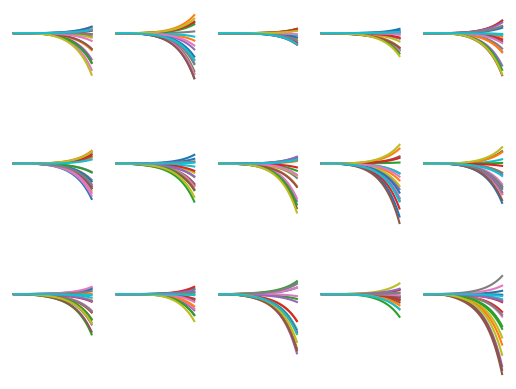

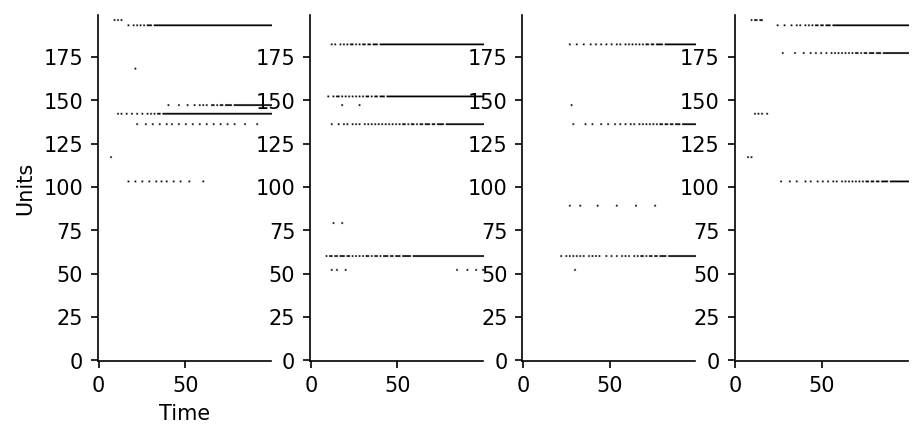

In [37]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_homo, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret

def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0 * mem
        dat[spk > 0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i == 0: 
            a0 = ax = plt.subplot(gs[i])
        else: 
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn_homo(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

# Plotting voltage traces
fig = plt.figure(dpi=100)
plot_voltage_traces(output)

# Plotting the hidden layer spiking activity for some input stimuli
nb_plt = 4
gs = GridSpec(1, nb_plt)
fig = plt.figure(figsize=(7, 3), dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T, cmap=plt.cm.gray_r, origin="lower")
    if i == 0:
        plt.xlabel("Time")
        plt.ylabel("Units")
    sns.despine()
    
# Calculate total spikes, average number of spikes per neuron, and number of neurons for each example in the batch
spk_numpy = spk_rec.detach().cpu().numpy()
total_spikes_per_example = np.sum(spk_numpy, axis=(1, 2)) * 14
number_of_neurons_per_example = spk_numpy.shape[2]
average_spikes_per_neuron_per_example = total_spikes_per_example / number_of_neurons_per_example

# Calculate overall average total spikes and average spikes per neuron across all examples
avg_total_spikes = np.mean(total_spikes_per_example)
avg_spikes_per_neuron = np.mean(average_spikes_per_neuron_per_example)

print(f"Average total spikes per test case across test set: {avg_total_spikes:.2f}")
print(f"Average number of spikes per neuron per second across test set: {avg_spikes_per_neuron:.2f}")
print(f"Number of neurons per example: {number_of_neurons_per_example}")


# Calculate total number of spikes, spikes per neuron, and average spikes per neuron
# total_spikes = spk_rec.sum().item()/batch_size_homo
# spikes_per_neuron = spk_rec.sum(dim=0).detach().cpu().numpy()
# average_spikes_per_neuron = np.mean(spikes_per_neuron)

# print(f"Total number of spikes: {total_spikes}")
# print(f"Average number of spikes per neuron: {average_spikes_per_neuron}")

# # Optionally, plot spikes per neuron
# fig = plt.figure(figsize=(10, 4), dpi=150)
# plt.bar(range(len(spikes_per_neuron)), spikes_per_neuron)
# plt.xlabel("Neuron")
# plt.ylabel("Number of spikes")
# plt.title("Spikes per neuron")
# plt.show()

# Hetero

In [41]:
def run_snn_hetero(inputs):
    device, dtype = inputs.device, inputs.dtype
    # print(thresholds_1)

    # Initialize memory and synaptic variables
    syn = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size_hetero, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_1
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        new_syn = alpha_hetero_1 * syn + h1
        new_mem = beta_hetero_1 * (mem - rest_1) + rest_1 + (1 - beta_hetero_1) * syn - rst * (thresholds_1 - reset_1)

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size_hetero, nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size_hetero, nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        # print(alpha_hetero.shape)
        new_flt = alpha_hetero_2 * flt + h2[:, t]  # Assume alpha for the output layer
        # new_out = beta_hetero_2 * out + flt
        new_out = beta_hetero_2 * out + (1 - beta_hetero_2)*flt  # Assume beta for the output layer

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [61]:
# loaded_weights_snn = torch.load('Hetero/1_Hetero/best/best_snn.pth')
# loaded_weights_snn = torch.load('Hetero/1_Hetero/best_no_reg/best_snn.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/best/best_snn.pth')

loaded_weights_snn = torch.load('SHD_Results/best_hetero_og_3/best_snn.pth')
# loaded_weights_snn = torch.load('SHD_Results/epochs_hetero_og/snn_48.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/best_no_reg/best_snn.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/best_new_reg_2/best_snn.pth')


# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])
print(loaded_weights_snn['epoch'])

0.7897321428571429
17


In [62]:
batch_size_hetero = 64

/var/tmp/pbs.9572708.pbs/ipykernel_272445/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Average total spikes per test case across test set: 6240.72
Average number of spikes per neuron per second across test set: 31.20
Number of neurons per example: 200


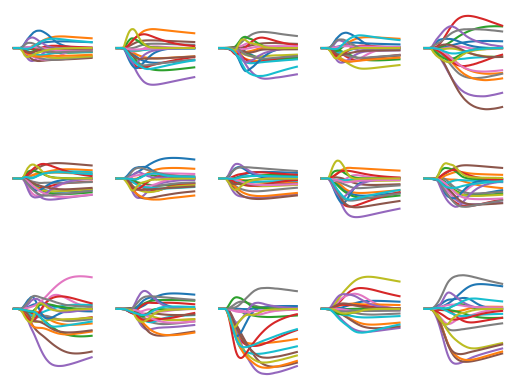

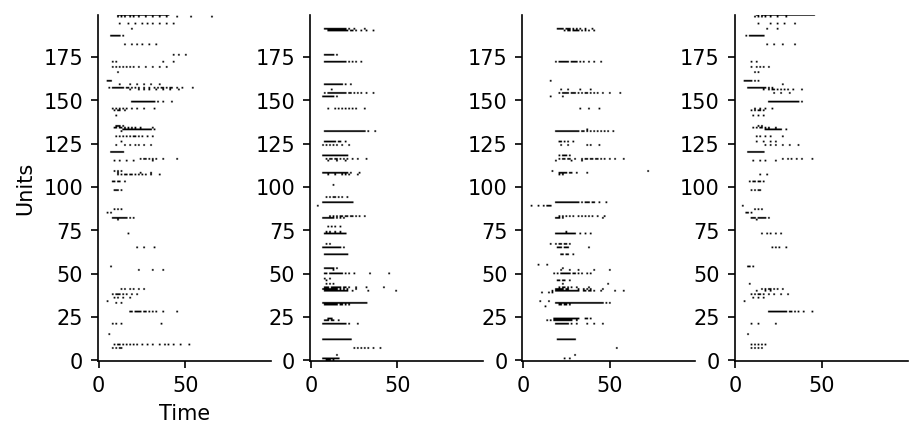

In [63]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn_hetero(x_batch.to_dense())
mem_rec, spk_rec = other_recordings
fig=plt.figure(dpi=100)
plot_voltage_traces(output)
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()
    
# Calculate total spikes, average number of spikes per neuron, and number of neurons for each example in the batch
spk_numpy = spk_rec.detach().cpu().numpy()
total_spikes_per_example = np.sum(spk_numpy, axis=(1, 2)) * 14
number_of_neurons_per_example = spk_numpy.shape[2]
average_spikes_per_neuron_per_example = total_spikes_per_example / number_of_neurons_per_example

# Calculate overall average total spikes and average spikes per neuron across all examples
avg_total_spikes = np.mean(total_spikes_per_example)
avg_spikes_per_neuron = np.mean(average_spikes_per_neuron_per_example)

print(f"Average total spikes per test case across test set: {avg_total_spikes:.2f}")
print(f"Average number of spikes per neuron per second across test set: {avg_spikes_per_neuron:.2f}")
print(f"Number of neurons per example: {number_of_neurons_per_example}")



# Voltage For Hybrids

## HOMO

In [64]:
class MLP_alpha_beta_single1(nn.Module):
    def __init__(self):
        super(MLP_alpha_beta_single1, self).__init__()
        self.input_size = 928
        self.hidden_size = 128
        self.output_size = 7
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[2].weight[i, i] = 1

In [72]:
class MLP_no_hidden(nn.Module):
    def __init__(self):
        super(MLP_no_hidden, self).__init__()
        self.input_size = 928
        self.output_size = 7
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.output_size),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

In [80]:
def run_snn_hybrid_alpha_beta_spikes_homo(inputs, mlp, mlp_interval, batch_size_MLP):

    # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
    alpha_1_local = alpha_homo_1
    beta_1_local = beta_homo_1
    thresholds_local = thresholds_1
    reset_local = reset_1
    rest_local = rest_1
    alpha_2_local = alpha_homo_2
    beta_2_local = beta_homo_2
    alpha_1_local = alpha_1_local.expand(batch_size_MLP, 1)
    beta_1_local = beta_1_local.expand(batch_size_MLP, 1)
    thresholds_local = thresholds_local.expand(batch_size_MLP, 1)
    reset_local = reset_local.expand(batch_size_MLP, 1)
    rest_local = rest_local.expand(batch_size_MLP, 1)
    alpha_2_local = alpha_2_local.expand(batch_size_MLP, 1)
    beta_2_local = beta_2_local.expand(batch_size_MLP, 1)

    # Initialize synaptic and membrane potentials
    syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes
    mem_rec = []
    spk_rec = []

    test = 0

    # Initialize outputs for the hidden layer
    out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

    # Prepare readout layer variables
    flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out_rec = [out2]

    for t in range(nb_steps):
        # Compute hidden layer activity
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_local
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        # Update synaptic and membrane potentials
        syn = alpha_1_local * syn + h1

        mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

        # Record membrane potentials and spikes
        mem_rec.append(mem)
        spk_rec.append(out)


        # Now compute h2 on the fly
        h2_t = torch.einsum("ab,bc->ac", (out, w2))
#         flt2 = alpha_1_local * flt2 + h2_t
#         out2 = beta_1_local * out2 + flt2*(1-beta_1_local)
        flt2 = alpha_2_local * flt2 + h2_t
        out2 = beta_2_local * out2 + flt2*(1-beta_2_local)
        
        out_rec.append(out2)

         # Flatten and concatenate spikes for each item in the batch
        input_spikes_flat = inputs[:, t, :].reshape(batch_size_MLP, -1)  # Shape: [batch_size, 700]
        hidden_spikes_flat = out.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 200]
        output_spikes_flat = out2.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 20]

        # Time tensor
        time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

        # Concatenate tensors
        mlp_input = torch.cat([
            alpha_1_local, beta_1_local, 
            thresholds_local, reset_local, rest_local,
            alpha_2_local, beta_2_local,
            time_tensor,
            input_spikes_flat, hidden_spikes_flat, output_spikes_flat
        ], dim=1)

        # Process with MLP (in a single call for the whole batch)
        mlp_outputs = mlp(mlp_input)

        if t % mlp_interval == 0 and t != 0:
            # Update alpha_local and beta_local based on MLP outputs
            alpha_1_local = mlp_outputs[:, 0].unsqueeze(1)
            beta_1_local = mlp_outputs[:, 1].unsqueeze(1)
            threshold_local = (mlp_outputs[:, 2] + 0.5).unsqueeze(1)
            reset_local = (mlp_outputs[:, 3] - 0.5).unsqueeze(1)
            rest_local = (mlp_outputs[:, 4] - 0.5).unsqueeze(1)
            alpha_2_local = mlp_outputs[:, 5].unsqueeze(1)
            beta_2_local = mlp_outputs[:, 6].unsqueeze(1)


    # Stack recordings for output
    mem_rec = torch.stack(mem_rec, dim=1).to(device)
    spk_rec = torch.stack(spk_rec, dim=1).to(device)
    out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

    other_recs = [mem_rec, spk_rec]

    return out_rec, other_recs

In [ ]:
def compute_classification_accuracy_MLP_homo(x_data, y_data, mlp, mlp_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_homo, nb_steps, nb_inputs, max_time, shuffle=False):
        output, _ = run_snn_hybrid_alpha_beta_spikes_homo(x_local.to_dense(),  mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_homo)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [87]:
print(compute_classification_accuracy_MLP_homo(x_test,y_test, mlp_mlp, 10))

/var/tmp/pbs.9572708.pbs/ipykernel_272445/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


0.8263392857142857


In [92]:
# loaded_weights_snn = torch.load('Homo/3_Homo/hybrid_new_reg_hidden/best_snn.pth')
loaded_weights_snn = torch.load('Homo/3_Homo/hybrid_new_reg/best_snn.pth')
loaded_weights_snn = torch.load('Homo/3_Homo/hybrid/best_snn.pth')


# loaded_weights_snn = torch.load('19_snn_reg_2.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.7861607142857143


In [93]:
# mlp_state_dict = torch.load('Homo/3_Homo/hybrid_new_reg_hidden/best_mlp.pt')
mlp_state_dict = torch.load('Homo/3_Homo/hybrid_new_reg/best_mlp.pt')
mlp_state_dict = torch.load('Homo/3_Homo/hybrid/best_mlp.pt')

# Apply the state dictionary to the model
# mlp_mlp = MLP_alpha_beta_single1().to(device)
mlp_mlp = MLP_no_hidden().to(device)
mlp_mlp.load_state_dict(mlp_state_dict)

<All keys matched successfully>

/var/tmp/pbs.9572708.pbs/ipykernel_272445/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Average total spikes per test case across test set: 697.27
Average number of spikes per neuron per second across test set: 3.49
Number of neurons per example: 200


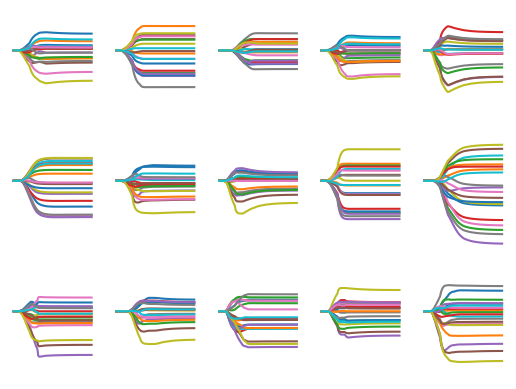

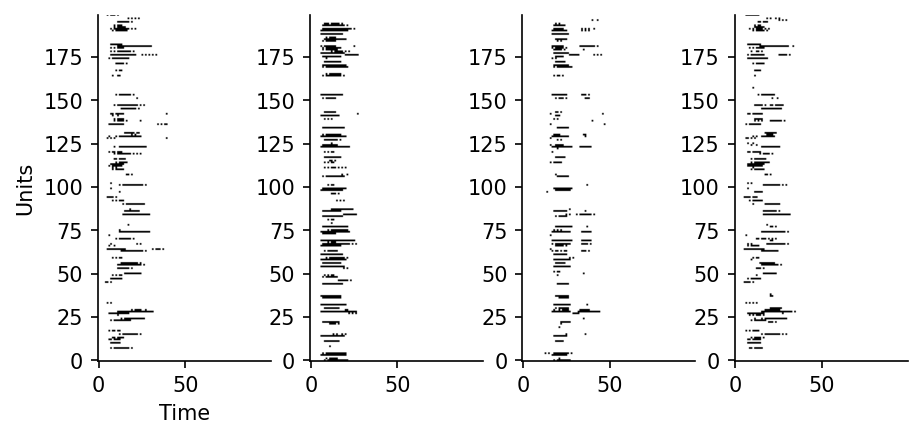

In [95]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_homo, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn_hybrid_alpha_beta_spikes_homo(x_batch.to_dense(), mlp_mlp, 10, 64)
mem_rec, spk_rec = other_recordings
fig=plt.figure(dpi=100)
plot_voltage_traces(output)
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()
    
# Calculate total spikes, average number of spikes per neuron, and number of neurons for each example in the batch
spk_numpy = spk_rec.detach().cpu().numpy()
total_spikes_per_example = np.sum(spk_numpy, axis=(1, 2)) 
number_of_neurons_per_example = spk_numpy.shape[2]
average_spikes_per_neuron_per_example = total_spikes_per_example / number_of_neurons_per_example

# Calculate overall average total spikes and average spikes per neuron across all examples
avg_total_spikes = np.mean(total_spikes_per_example)
avg_spikes_per_neuron = np.mean(average_spikes_per_neuron_per_example)

print(f"Average total spikes per test case across test set: {avg_total_spikes:.2f}")
print(f"Average number of spikes per neuron per second across test set: {avg_spikes_per_neuron:.2f}")
print(f"Number of neurons per example: {number_of_neurons_per_example}")

## HETERO

In [2]:
class hetero_mlp_a_b_spikes(nn.Module):
    def __init__(self):
        super(hetero_mlp_a_b_spikes, self).__init__()
        self.input_size = 1961 #(adding 40 for alpha and beta 2)
        self.hidden_size = 2048
        self.output_size = 1040 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[2].weight[i, i] = 1

In [3]:
def run_snn_hybrid_alpha_beta_spikes_HETERO(inputs, mlp, mlp_interval, batch_size_MLP):

    # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
    alpha_1_local = alpha_hetero_1
    beta_1_local = beta_hetero_1
    thresholds_local = thresholds_1
    reset_local = reset_1
    rest_local = rest_1
    alpha_2_local = alpha_hetero_2
    beta_2_local = beta_hetero_2
    alpha_1_local = alpha_1_local.expand(batch_size_MLP, 200)
    beta_1_local = beta_1_local.expand(batch_size_MLP, 200)
    thresholds_local = thresholds_local.expand(batch_size_MLP, 200)
    reset_local = reset_local.expand(batch_size_MLP, 200)
    rest_local = rest_local.expand(batch_size_MLP, 200)
    alpha_2_local = alpha_2_local.expand(batch_size_MLP, 20)
    beta_2_local = beta_2_local.expand(batch_size_MLP, 20)

    # Initialize synaptic and membrane potentials
    syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes
    mem_rec = []
    spk_rec = []

    # Initialize outputs for the hidden layer
    out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

    # Prepare readout layer variables
    flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out_rec = [out2]

    for t in range(nb_steps):

        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_local
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        # Update synaptic and membrane potentials
        syn = alpha_1_local * syn + h1
        mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

        # Record membrane potentials and spikes
        mem_rec.append(mem)
        spk_rec.append(out)

        # Now compute h2 on the fly
        h2_t = torch.einsum("ab,bc->ac", (out, w2))
        flt2 = alpha_2_local * flt2 + h2_t
#         out2 = beta_2_local * out2 + flt2
        out2 = beta_2_local * out2 + flt2*(1-beta_2_local)
        out_rec.append(out2)

         # Flatten and concatenate spikes for each item in the batch
        input_spikes_flat = inputs[:, t, :].reshape(batch_size_MLP, -1)  # Shape: [batch_size, 700]
        hidden_spikes_flat = out.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 200]
        output_spikes_flat = out2.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 20]

        # Time tensor
        time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

        # Concatenate tensors
        mlp_input = torch.cat([
            alpha_1_local, beta_1_local, thresholds_local, reset_local, rest_local,
            alpha_2_local, beta_2_local,
            time_tensor,
            input_spikes_flat, hidden_spikes_flat, output_spikes_flat
        ], dim=1)

        # Process with MLP (in a single call for the whole batch)

        if t % mlp_interval == 0:
            mlp_outputs = mlp(mlp_input)
            # Update alpha_local and beta_local based on MLP outputs
            alpha_1_local, beta_1_local = mlp_outputs[:, :200], mlp_outputs[:, 200:400]
            threshold_local = mlp_outputs[:, 400:600] + 0.5
            reset_local, rest_local = mlp_outputs[:, 600:800] - 0.5, mlp_outputs[:, 800:1000] - 0.5
            alpha_2_local, beta_2_local = mlp_outputs[:, 1000:1020], mlp_outputs[:, 1020:1040]

    # Stack recordings for output
    mem_rec = torch.stack(mem_rec, dim=1).to(device)
    spk_rec = torch.stack(spk_rec, dim=1).to(device)
    out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

    other_recs = [mem_rec, spk_rec]

    return out_rec, other_recs

In [11]:
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_2048/snn_9.pth')
# loaded_weights_snn = torch.load('epochs_hetero_og/snn_9.pth')
# loaded_weights_snn = torch.load('hybrid_hetero/snn_2048.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_new_reg/snn_7.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_new_reg_2/snn_6.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_no_reg_2/snn_10.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_1400_ts/snn_2.pth')

# loaded_weights_snn = torch.load('hybrid_hetero_new_reg_2_int_5_2/snn.pth')
loaded_weights_snn = torch.load('hybrid_hetero_new_reg_2_int_1/snn.pth')


# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.91875


In [7]:
# mlp_state_dict = torch.load('SHD_Results/hybrid_hetero_int/mlp_het_int_5.pt')
mlp_state_dict = torch.load('hybrid_hetero_new_reg_2_int_5/mlp_het_int_5.pt')

# Function to print shape of each layer's weights in state_dict
def print_state_dict_shapes(state_dict):
    for name, param in state_dict.items():
        print(f"{name}: {param.shape}")

# Print shapes of weights in state_dict
# print_state_dict_shapes(loaded_weights_snn)

# Apply the state dictionary to the model
# mlp_mlp = MLP_alpha_beta_single1().to(device)
mlp_mlp = hetero_mlp_a_b_spikes().to(device)
# Function to print shape of each layer's weights
def print_model_shapes(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.shape}")

# Print shapes of model's weights
# print_model_shapes(mlp_mlp)

mlp_mlp.load_state_dict(mlp_state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'hybrid_hetero_new_reg_2_int_5/mlp_het_int_5.pt'

/var/tmp/pbs.9572708.pbs/ipykernel_272445/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Average total spikes per test case across test set: 4703.12
Average number of spikes per neuron per second across test set: 23.52
Number of neurons per example: 200


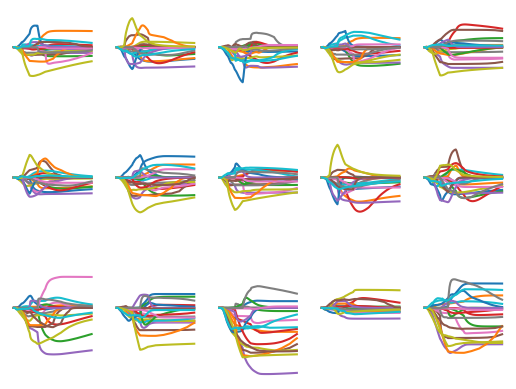

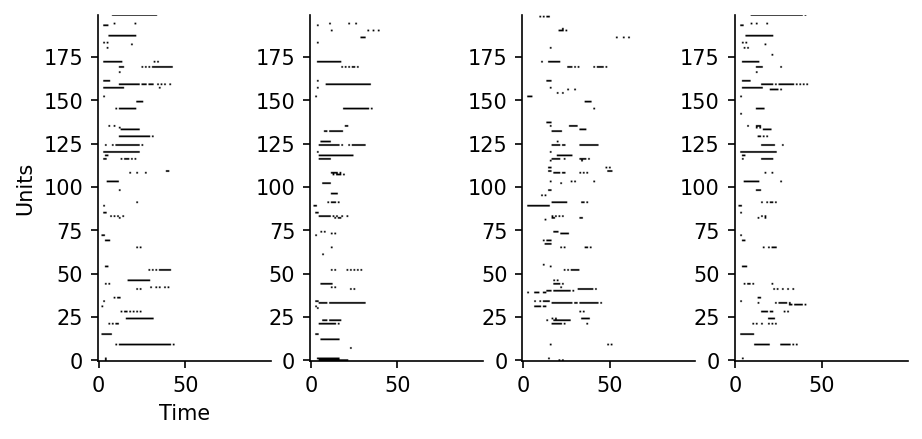

In [118]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
x_batch, y_batch = get_mini_batch(x_test, y_test)
mlp_interval = 10
output, other_recordings = run_snn_hybrid_alpha_beta_spikes_HETERO(x_batch.to_dense(), mlp_mlp, mlp_interval, 64)
mem_rec, spk_rec = other_recordings
fig=plt.figure(dpi=100)
plot_voltage_traces(output)
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()
    
# Calculate total spikes, average number of spikes per neuron, and number of neurons for each example in the batch
spk_numpy = spk_rec.detach().cpu().numpy()
total_spikes_per_example = np.sum(spk_numpy, axis=(1, 2)) * 14
number_of_neurons_per_example = spk_numpy.shape[2]
average_spikes_per_neuron_per_example = total_spikes_per_example / number_of_neurons_per_example

# Calculate overall average total spikes and average spikes per neuron across all examples
avg_total_spikes = np.mean(total_spikes_per_example)
avg_spikes_per_neuron = np.mean(average_spikes_per_neuron_per_example)

print(f"Average total spikes per test case across test set: {avg_total_spikes:.2f}")
print(f"Average number of spikes per neuron per second across test set: {avg_spikes_per_neuron:.2f}")
print(f"Number of neurons per example: {number_of_neurons_per_example}")

# MLP (HYBRID)

# HOMO

In [23]:
class MLP_alpha_beta_single1(nn.Module):
    def __init__(self):
        super(MLP_alpha_beta_single1, self).__init__()
        self.input_size = 928
        self.hidden_size = 128
        self.output_size = 7
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[2].weight[i, i] = 1

In [24]:
class MLP_no_hidden(nn.Module):
    def __init__(self):
        super(MLP_no_hidden, self).__init__()
        self.input_size = 928
        self.output_size = 7
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.output_size),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

In [25]:
class homo_mlp_a_b_spikes(nn.Module):
    def __init__(self):
        super(homo_mlp_a_b_spikes, self).__init__()
        self.input_size = 928
        self.hidden_size1 = 2782
        self.hidden_size2 = 2782
        self.output_size = 7

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size1),
            # nn.BatchNorm1d(self.hidden_size1),  # Batch normalization
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),  # Dropout
            nn.Linear(self.hidden_size1, self.hidden_size2),
            # nn.BatchNorm1d(self.hidden_size2),  # Batch normalization
            nn.ReLU(),
            # nn.Dropout(p=dropout_rate),  # Dropout
            nn.Linear(self.hidden_size2, self.output_size),
            nn.Sigmoid()
        )

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(self.output_size):
                self.layers[2].weight[i, i] = 1

            # Initialize last layer weights and biases
            self.layers[4].weight.fill_(0)
            self.layers[4].bias.fill_(0)

            # Ensure that the first 1000 inputs pass directly through to the output
            for i in range(self.output_size):
                self.layers[4].weight[i, i] = 1


In [26]:
# input_size = 3 + 700 + 200 + 20
# hidden_size = 512
# output_size = 2

# class MLP_alpha_beta_single_spikes(nn.Module):
#     def __init__(self):
#         super(MLP_alpha_beta_single_spikes, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, output_size),
#             nn.Sigmoid()
#         )
#         self.init_weights()

#     def forward(self, x):
#         return self.layers(x)

#     def init_weights(self):
#         with torch.no_grad():
#             # Initialize first layer weights and biases
#             self.layers[0].weight.fill_(0)
#             self.layers[0].bias.fill_(0)
#             self.layers[0].weight[:, 0] = 1  # Pass the first input
#             self.layers[0].weight[:, 1] = 1  # Pass the second input

#             # Initialize second layer weights and biases
#             self.layers[2].weight.fill_(0)
#             self.layers[2].bias.fill_(0)
#             self.layers[2].weight[0, 0] = 1  # Pass the first input to the first output
#             self.layers[2].weight[1, 1] = 1  # Pass the second input to the second output

In [12]:
class MLP_alpha_beta_single1(nn.Module):
    def __init__(self):
        super(MLP_alpha_beta_single1, self).__init__()
        self.input_size = 8
        self.hidden_size = 406
        self.output_size = 7
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )
        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)
            for i in range(self.output_size):
                self.layers[2].weight[i, i] = 1

In [13]:
def run_snn_hybrid_alpha_beta_spikes_homo(inputs, mlp, mlp_interval, batch_size_MLP):

    # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
    alpha_1_local = alpha_homo_1
    beta_1_local = beta_homo_1
    thresholds_local = thresholds_1
    reset_local = reset_1
    rest_local = rest_1
    alpha_2_local = alpha_homo_2
    beta_2_local = beta_homo_2
    alpha_1_local = alpha_1_local.expand(batch_size_MLP, 1)
    beta_1_local = beta_1_local.expand(batch_size_MLP, 1)
    thresholds_local = thresholds_local.expand(batch_size_MLP, 1)
    reset_local = reset_local.expand(batch_size_MLP, 1)
    rest_local = rest_local.expand(batch_size_MLP, 1)
    alpha_2_local = alpha_2_local.expand(batch_size_MLP, 1)
    beta_2_local = beta_2_local.expand(batch_size_MLP, 1)

    # Initialize synaptic and membrane potentials
    syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes
    mem_rec = []
    spk_rec = []

    test = 0

    # Initialize outputs for the hidden layer
    out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

    # Prepare readout layer variables
    flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out_rec = [out2]

    for t in range(nb_steps):
        # Compute hidden layer activity
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_local
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        # Update synaptic and membrane potentials
        syn = alpha_1_local * syn + h1

        mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

        # Record membrane potentials and spikes
        mem_rec.append(mem)
        spk_rec.append(out)


        # Now compute h2 on the fly
        h2_t = torch.einsum("ab,bc->ac", (out, w2))
#         flt2 = alpha_1_local * flt2 + h2_t
#         out2 = beta_1_local * out2 + flt2*(1-beta_1_local)
        flt2 = alpha_2_local * flt2 + h2_t
        out2 = beta_2_local * out2 + flt2*(1-beta_2_local)
        
        out_rec.append(out2)

         # Flatten and concatenate spikes for each item in the batch
        input_spikes_flat = inputs[:, t, :].reshape(batch_size_MLP, -1)  # Shape: [batch_size, 700]
        hidden_spikes_flat = out.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 200]
        output_spikes_flat = out2.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 20]

        # Time tensor
        time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

        # Concatenate tensors
        mlp_input = torch.cat([
            alpha_1_local, beta_1_local, 
            thresholds_local, reset_local, rest_local,
            alpha_2_local, beta_2_local,
            time_tensor,
#             input_spikes_flat, hidden_spikes_flat, output_spikes_flat
        ], dim=1)

        # Process with MLP (in a single call for the whole batch)
        mlp_outputs = mlp(mlp_input)

        if t % mlp_interval == 0 and t != 0:
            # Update alpha_local and beta_local based on MLP outputs
            alpha_1_local = mlp_outputs[:, 0].unsqueeze(1)
            beta_1_local = mlp_outputs[:, 1].unsqueeze(1)
            threshold_local = (mlp_outputs[:, 2] + 0.5).unsqueeze(1)
            reset_local = (mlp_outputs[:, 3] - 0.5).unsqueeze(1)
            rest_local = (mlp_outputs[:, 4] - 0.5).unsqueeze(1)
            alpha_2_local = mlp_outputs[:, 5].unsqueeze(1)
            beta_2_local = mlp_outputs[:, 6].unsqueeze(1)


    # Stack recordings for output
    mem_rec = torch.stack(mem_rec, dim=1).to(device)
    spk_rec = torch.stack(spk_rec, dim=1).to(device)
    out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

    other_recs = [mem_rec, spk_rec]

    return out_rec, other_recs


In [14]:
def compute_classification_accuracy_MLP_homo(x_data, y_data, mlp, mlp_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_homo, nb_steps, nb_inputs, max_time, shuffle=False):
        output, _ = run_snn_hybrid_alpha_beta_spikes_homo(x_local.to_dense(),  mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_homo)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [15]:
def train_hybrid(mlp, x_data, y_data, lr=1e-3, nb_epochs=10, mlp_interval=10):

    snn_params = [w1, w2, v1, alpha_homo_1, beta_homo_1,
              thresholds_1, reset_1, rest_1, alpha_homo_2, beta_homo_2]
    


    # Optimizers
    combined_params = [
        {'params': snn_params, 'lr': lr},  # Parameters for SNN with specific learning rate
        {'params': mlp.parameters(), 'lr': lr}  # Parameters for MLP with its own learning rate
    ]

    # Using a single optimizer for both SNN and MLP
    combined_optimizer = torch.optim.Adam(combined_params)


    #Loss functions
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    best_accuracy = 0

    loss_hist = []
    for epoch in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        accs = []
#         print(alpha_homo_1)
#         print(beta_homo_2)
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_homo, nb_steps, nb_inputs, max_time):
                output, recs = run_snn_hybrid_alpha_beta_spikes_homo(inputs=x_local.to_dense(), mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_homo)
                _ , spks = recs
                m, _ = torch.max(output,1)

                _,am=torch.max(m,1)      # argmax over output units
                tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
                accs.append(tmp)

                log_p_y = log_softmax_fn(m)
                ground_loss = loss_fn(log_p_y, y_local)
                reg_loss = 1e-6*torch.sum(spks) # L1 loss on total number of spikes
                reg_loss += 1e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron

                loss_MLP = ground_loss + reg_loss

                combined_optimizer.zero_grad()
                loss_MLP.backward()
                combined_optimizer.step()

                local_loss.append(loss_MLP.item())
                local_ground_loss.append(ground_loss.item())
                local_reg_loss.append(reg_loss.item())


        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print(f"Epoch {epoch+1}: loss={mean_loss:.5f}")
        print("ground_loss", np.mean(local_ground_loss))
        print("reg_loss", np.mean(local_reg_loss))
        current_accuracy = compute_classification_accuracy_MLP_homo(x_test, y_test, mlp, mlp_interval)
        print(f"Epoch {epoch+1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

        # Print the best accuracy so far
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy

            directory = 'hybrid_homo'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            best_model_state = mlp_mlp.state_dict()

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'best_mlp_smol.pt')
            torch.save(best_model_state, file_path)

            # Save parameters only when a new best accuracy is achieved
            # Create a dictionary of current parameters to save
            saved_params_hetero = {
                'w1': w1.clone(),
                'w2': w2.clone(),
                'v1': v1.clone(),
                'alpha': alpha_homo_1.clone(),
                'beta': beta_homo_1.clone(),
                'threshold': thresholds_1.clone(),
                'reset': reset_1.clone(),
                'rest': rest_1.clone(),
                'alpha_2': alpha_homo_2.clone(),
                'beta_2': beta_homo_2.clone()
            }

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'best_snn_smol.pth')
            torch.save({
                'epoch': epoch + 1,
                'accuracy': best_accuracy,
                'params': saved_params_hetero,
                'loss': loss_hist
            }, file_path)
        else:
            print("Best ", best_accuracy)

    return loss_hist

In [3]:
# loaded_weights_snn = torch.load('Hetero/1_Hetero/best/best_snn.pth')
# loaded_weights_snn = torch.load('Homo/3_Homo/epochs_no_reg/snn_6.pth')
loaded_weights_snn = torch.load('Homo/3_Homo/epochs_new_reg_1400_ts/snn_9.pth')
# loaded_weights_snn = torch.load('19_snn_reg_2.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])
print(alpha_homo_1)
print(beta_homo_1)
print(alpha_homo_2)
print(beta_homo_2)
print(thresholds_1)
print(reset_1)
print(rest_1)

0.04598214285714286
Parameter containing:
tensor([[0.9048]], requires_grad=True)
Parameter containing:
tensor([[0.9512]], requires_grad=True)
Parameter containing:
tensor([[0.9048]], requires_grad=True)
Parameter containing:
tensor([[0.9512]], requires_grad=True)
Parameter containing:
tensor([[0.9891]], requires_grad=True)
Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([[0.]], requires_grad=True)


In [7]:
# print(compute_classification_accuracy_homo(x_train,y_train))

In [ ]:
nb_epochs_mlp = 50
batch_size_homo = 64
# mlp_mlp = MLP_alpha_beta_single1().to(device)
mlp_mlp = MLP_alpha_beta_single1().to(device)
loss_hist_MLP = train_hybrid(mlp_mlp, x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_mlp, mlp_interval = 10)

/var/tmp/pbs.9513059.pbs/ipykernel_782359/2872161497.py:68: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=2.06529
ground_loss 1.909318310069287
reg_loss 0.15596669085147813
Epoch 1: Train= 0.48278 Test Accuracy=0.58125
Epoch 2: loss=1.19956
ground_loss 1.046757379854758
reg_loss 0.1528035134781064
Epoch 2: Train= 0.69107 Test Accuracy=0.67143
Epoch 3: loss=0.84403
ground_loss 0.7003570553355329
reg_loss 0.1436718203655378
Epoch 3: Train= 0.77178 Test Accuracy=0.70402
Epoch 4: loss=0.66180
ground_loss 0.5309123121143327
reg_loss 0.13088887214191317
Epoch 4: Train= 0.83415 Test Accuracy=0.71875
Epoch 5: loss=0.55215
ground_loss 0.42859829528125254
reg_loss 0.12355537131780714
Epoch 5: Train= 0.86848 Test Accuracy=0.71830
Best  0.71875
Epoch 6: loss=0.48495
ground_loss 0.3670850196691949
reg_loss 0.11786768209981167
Epoch 6: Train= 0.88890 Test Accuracy=0.71473
Best  0.71875
Epoch 7: loss=0.43273
ground_loss 0.3203017011167496
reg_loss 0.11242541923063008
Epoch 7: Train= 0.90293 Test Accuracy=0.74107
Epoch 8: loss=0.41287
ground_loss 0.30881533519489557
reg_loss 0.10405438880282

# HETERO

In [14]:
class hetero_mlp_a_b_spikes(nn.Module):
    def __init__(self):
        super(hetero_mlp_a_b_spikes, self).__init__()
        self.input_size = 1961 #(adding 40 for alpha and beta 2)
        self.hidden_size1 = 2048
        self.hidden_size2 = 2048
        self.output_size = 1040 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, self.output_size),
            nn.Sigmoid()
        )

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[2].weight[i, i] = 1

            # Initialize last layer weights and biases
            self.layers[4].weight.fill_(0)
            self.layers[4].bias.fill_(0)

            # Ensure that the first 1000 inputs pass directly through to the output
            for i in range(1040):
                self.layers[4].weight[i, i] = 1


In [31]:
class hetero_mlp_a_b_spikes(nn.Module):
    def __init__(self):
        super(hetero_mlp_a_b_spikes, self).__init__()
        self.input_size = 1961 #(adding 40 for alpha and beta 2)
        self.hidden_size = 2048
        self.output_size = 1040 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[0].weight[i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[2].weight[i, i] = 1

In [32]:
# class hetero_mlp_no_hidden(nn.Module):
#     def __init__(self):
#         super(hetero_mlp_no_hidden, self).__init__()
#         self.input_size = 1961 #(adding 40 for alpha and beta 2)
#         self.output_size = 1040 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

#         self.layers = nn.Sequential(
#             nn.Linear(self.input_size, self.output_size),
#             nn.Sigmoid()
#         )
#         self.init_weights()

#     def forward(self, x):
#         return self.layers(x)

#     def init_weights(self):
#         with torch.no_grad():
#             # Initialize first layer weights and biases
#             self.layers[0].weight.fill_(0)
#             self.layers[0].bias.fill_(0)

#             # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
#             for i in range(self.output_size):
#                 self.layers[0].weight[i, i] = 1

In [55]:
def run_snn_hybrid_alpha_beta_spikes_HETERO(inputs, mlp, mlp_interval, batch_size_MLP):

    # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
    alpha_1_local = alpha_hetero_1
    beta_1_local = beta_hetero_1
    thresholds_local = thresholds_1
    reset_local = reset_1
    rest_local = rest_1
    alpha_2_local = alpha_hetero_2
    beta_2_local = beta_hetero_2
    alpha_1_local = alpha_1_local.expand(batch_size_MLP, 200)
    beta_1_local = beta_1_local.expand(batch_size_MLP, 200)
    thresholds_local = thresholds_local.expand(batch_size_MLP, 200)
    reset_local = reset_local.expand(batch_size_MLP, 200)
    rest_local = rest_local.expand(batch_size_MLP, 200)
    alpha_2_local = alpha_2_local.expand(batch_size_MLP, 20)
    beta_2_local = beta_2_local.expand(batch_size_MLP, 20)

    # Initialize synaptic and membrane potentials
    syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes
    mem_rec = []
    spk_rec = []

    # Initialize outputs for the hidden layer
    out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

    # Prepare readout layer variables
    flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out_rec = [out2]

    for t in range(nb_steps):

        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_local
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        # Update synaptic and membrane potentials
        syn = alpha_1_local * syn + h1
        mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

        # Record membrane potentials and spikes
        mem_rec.append(mem)
        spk_rec.append(out)

        # Now compute h2 on the fly
        h2_t = torch.einsum("ab,bc->ac", (out, w2))
        flt2 = alpha_2_local * flt2 + h2_t
#         out2 = beta_2_local * out2 + flt2
        out2 = beta_2_local * out2 + flt2*(1-beta_2_local)
        out_rec.append(out2)

         # Flatten and concatenate spikes for each item in the batch
        input_spikes_flat = inputs[:, t, :].reshape(batch_size_MLP, -1)  # Shape: [batch_size, 700]
        hidden_spikes_flat = out.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 200]
        output_spikes_flat = out2.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 20]

        # Time tensor
        time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

        # Concatenate tensors
        mlp_input = torch.cat([
            alpha_1_local, beta_1_local, thresholds_local, reset_local, rest_local,
            alpha_2_local, beta_2_local,
            time_tensor,
            input_spikes_flat, hidden_spikes_flat, output_spikes_flat
        ], dim=1)

        # Process with MLP (in a single call for the whole batch)

        if t % mlp_interval == 0:
            mlp_outputs = mlp(mlp_input)
            # Update alpha_local and beta_local based on MLP outputs
            alpha_1_local, beta_1_local = mlp_outputs[:, :200], mlp_outputs[:, 200:400]
            threshold_local = mlp_outputs[:, 400:600] + 0.5
            reset_local, rest_local = mlp_outputs[:, 600:800] - 0.5, mlp_outputs[:, 800:1000] - 0.5
            alpha_2_local, beta_2_local = mlp_outputs[:, 1000:1020], mlp_outputs[:, 1020:1040]

    # Stack recordings for output
    mem_rec = torch.stack(mem_rec, dim=1).to(device)
    spk_rec = torch.stack(spk_rec, dim=1).to(device)
    out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

    other_recs = [mem_rec, spk_rec]

    return out_rec, other_recs


In [76]:
# def run_snn_hybrid_alpha_beta_spikes_HETERO(inputs, mlp, mlp_interval, batch_size_MLP):

#     # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
#     alpha_1_local = alpha_hetero_1
#     beta_1_local = beta_hetero_1
#     thresholds_local = thresholds_1
#     reset_local = reset_1
#     rest_local = rest_1
#     alpha_2_local = alpha_hetero_2
#     beta_2_local = beta_hetero_2
#     alpha_1_local = alpha_1_local.expand(batch_size_MLP, 200)
#     beta_1_local = beta_1_local.expand(batch_size_MLP, 200)
#     thresholds_local = thresholds_local.expand(batch_size_MLP, 200)
#     reset_local = reset_local.expand(batch_size_MLP, 200)
#     rest_local = rest_local.expand(batch_size_MLP, 200)
#     alpha_2_local = alpha_2_local.expand(batch_size_MLP, 20)
#     beta_2_local = beta_2_local.expand(batch_size_MLP, 20)

#     # Initialize synaptic and membrane potentials
#     syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
#     mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

#     # Initialize recordings for membrane potentials and spikes
#     mem_rec = []
#     spk_rec = []

#     # Initialize outputs for the hidden layer
#     out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
#     h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))

#     # Prepare readout layer variables
#     flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
#     out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
#     out_rec = [out2]

#     # Initialize running sums for spikes
#     input_spikes_sum = torch.zeros((batch_size_MLP, inputs.shape[2]), device=device, dtype=dtype)
#     hidden_spikes_sum = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
#     output_spikes_sum = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)

#     for t in range(nb_steps):

#         h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
#         mthr = mem - thresholds_local
#         out = spike_fn(mthr)
#         rst = torch.zeros_like(mem)
#         c = (mthr > 0)
#         rst[c] = torch.ones_like(mem)[c]
#         # rst = out.detach() * reset  # Reset mechanism considering individual reset values

#         # Update synaptic and membrane potentials
#         syn = alpha_1_local * syn + h1
#         mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

#         # Record membrane potentials and spikes
#         mem_rec.append(mem)
#         spk_rec.append(out)

#         # Now compute h2 on the fly
#         h2_t = torch.einsum("ab,bc->ac", (out, w2))
#         flt2 = alpha_2_local * flt2 + h2_t
#         # out2 = beta_2_local * out2 + flt2
#         out2 = beta_2_local * out2 + flt2 * (1 - beta_2_local)
#         out_rec.append(out2)

#         # Update the running sums of spikes
#         input_spikes_sum += inputs[:, t, :]
#         hidden_spikes_sum += out
#         output_spikes_sum += out2

#         if t % mlp_interval == 0:
#             # Time tensor
#             time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

#             # Concatenate tensors
#             mlp_input = torch.cat([
#                 alpha_1_local, beta_1_local, thresholds_local, reset_local, rest_local,
#                 alpha_2_local, beta_2_local,
#                 time_tensor,
#                 input_spikes_sum, hidden_spikes_sum, output_spikes_sum
#             ], dim=1)

#             # Process with MLP (in a single call for the whole batch)
#             mlp_outputs = mlp(mlp_input)

#             # Update alpha_local and beta_local based on MLP outputs
#             alpha_1_local, beta_1_local = mlp_outputs[:, :200], mlp_outputs[:, 200:400]
#             thresholds_local = mlp_outputs[:, 400:600] + 0.5
#             reset_local, rest_local = mlp_outputs[:, 600:800] - 0.5, mlp_outputs[:, 800:1000] - 0.5
#             alpha_2_local, beta_2_local = mlp_outputs[:, 1000:1020], mlp_outputs[:, 1020:1040]

#             # Reset the running sums
#             input_spikes_sum = torch.zeros((batch_size_MLP, inputs.shape[2]), device=device, dtype=dtype)
#             hidden_spikes_sum = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
#             output_spikes_sum = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)

#     # Stack recordings for output
#     mem_rec = torch.stack(mem_rec, dim=1).to(device)
#     spk_rec = torch.stack(spk_rec, dim=1).to(device)
#     out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

#     other_recs = [mem_rec, spk_rec]

#     return out_rec, other_recs

In [77]:
def compute_classification_accuracy_MLP(x_data, y_data, mlp, mlp_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    with torch.no_grad():
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time, shuffle=False):
            output, _ = run_snn_hybrid_alpha_beta_spikes_HETERO(x_local.to_dense(),  mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_hetero)
            m,_= torch.max(output,1) # max over time
            _,am=torch.max(m,1)      # argmax over output units
            tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
    return np.mean(accs)

In [84]:
def train_hybrid(mlp, x_data, y_data, lr=1e-3, nb_epochs=10, mlp_interval=10):

    snn_params = [w1, w2, v1, 
                  alpha_hetero_1, beta_hetero_1,
                  thresholds_1, reset_1, rest_1,
                  alpha_hetero_2, beta_hetero_2]
#  

    # Optimizers
    combined_params = [
        {'params': snn_params, 'lr': lr},  # Parameters for SNN with specific learning rate
        {'params': mlp.parameters(), 'lr': lr}  # Parameters for MLP with its own learning rate
    ]

    # Using a single optimizer for both SNN and MLP
    combined_optimizer = torch.optim.Adam(combined_params)


    #Loss functions
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    best_accuracy = 0

    loss_hist = []
    for epoch in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        accs = []
#         print(w1)
#         print(alpha_hetero_1)
#         print(reset_1)
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time):
                output, recs = run_snn_hybrid_alpha_beta_spikes_HETERO(inputs=x_local.to_dense(), mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_hetero)
                _ , spks = recs
                m, _ = torch.max(output,1)

                _,am=torch.max(m,1)      # argmax over output units
                tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
                accs.append(tmp)

                log_p_y = log_softmax_fn(m)
                ground_loss = loss_fn(log_p_y, y_local)
#                 reg_loss = 1e-6*torch.sum(spks) # L1 loss on total number of spikes
#                 reg_loss += 1e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
                tot_num_neurons = nb_hidden + nb_outputs
                N_samp = 8128 # 8156
                T = nb_steps
                sl = 1
                thetal =0.01
                su = 0.06
                thetau = 100

                tmp = (torch.clamp((1/T)*torch.sum(spks, 1)-thetal, min=0.))**2
                L1_batch = torch.sum(tmp, (0, 1))
                reg_loss = (sl/(N_samp + tot_num_neurons))*L1_batch

                tmp2 = (torch.clamp((1/nb_hidden)*torch.sum(spks, (1, 2))-thetau, min=0.))**2
                L2_batch = torch.sum(tmp2)
                reg_loss += (su/N_samp)*L2_batch


                loss_MLP = ground_loss + reg_loss

                combined_optimizer.zero_grad()
                loss_MLP.backward()
                combined_optimizer.step()
                
                # Clamping the values
                with torch.no_grad():
                    alpha_hetero_1.clamp_(0.367, 0.995)
                    beta_hetero_1.clamp_(0.367, 0.995)
                    alpha_hetero_2.clamp_(0.367, 0.995)
                    beta_hetero_2.clamp_(0.367, 0.995)
                    thresholds_1.clamp_(0.5, 1.5)

                local_loss.append(loss_MLP.item())
                local_ground_loss.append(ground_loss.item())
                local_reg_loss.append(reg_loss.item())


        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print(f"Epoch {epoch+1}: loss={mean_loss:.5f}")
        print("ground_loss", np.mean(local_ground_loss))
        print("reg_loss", np.mean(local_reg_loss))
        current_accuracy = compute_classification_accuracy_MLP(x_test, y_test, mlp, mlp_interval)
        print(f"Epoch {epoch+1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

        # Print the best accuracy so far
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy

            directory = 'hybrid_hetero_new_reg_2_int_5_2'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            best_model_state = mlp_mlp.state_dict()

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'mlp.pt')
            torch.save(best_model_state, file_path)

            # Save parameters only when a new best accuracy is achieved
            # Create a dictionary of current parameters to save
            saved_params_hetero = {
                'w1': w1.clone(),
                'w2': w2.clone(),
                'v1': v1.clone(),
                'alpha': alpha_hetero_1.clone(),
                'beta': beta_hetero_1.clone(),
                'threshold': thresholds_1.clone(),
                'reset': reset_1.clone(),
                'rest': rest_1.clone(),
                'alpha_2': alpha_hetero_2.clone(),
                'beta_2': beta_hetero_2.clone()
            }

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'snn.pth')
            torch.save({
                'epoch': epoch + 1,
                'accuracy': best_accuracy,
                'params': saved_params_hetero,
                'loss': loss_hist
            }, file_path)
        else:
            print("Best", best_accuracy)

    return loss_hist

In [8]:
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_2048/snn_9.pth')
# loaded_weights_snn = torch.load('epochs_hetero_og/snn_9.pth')
# loaded_weights_snn = torch.load('hybrid_hetero/snn_2048.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_new_reg/snn_7.pth')
loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_new_reg_2/snn_6.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_no_reg_2/snn_10.pth')
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_1400_ts/snn_2.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.7535714285714286


In [86]:
# # loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-4/epochs_hetero/snn_54.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-4/best_hetero/best_snn.pth')
# print(loaded_weights_snn['train_acc_hist'])
# print(loaded_weights_snn['test_acc_hist'])
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero/best_hetero/best_snn.pth')
# print(loaded_weights_snn['train_acc_hist'])
# print(loaded_weights_snn['test_acc_hist'])

In [12]:
import torch
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero/epochs_hetero/snn_46.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo/epochs/snn_45.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-3/epochs_hetero/snn_70.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-4/epochs_hetero/snn_54.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo_lr_1e-3/epochs/snn_69.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_no_reg/epochs_hetero/snn_71.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo_no_reg/epochs/snn_68.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_512/epochs_hetero/snn_28.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero/snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo/epochs/snn_66.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_int_5/epochs/snn_64.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo_no_reg/epochs/snn_43.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_no_reg/epochs/snn_22.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_Double_Hetero/best_double_hetero.pth', map_location=torch.device('cpu'))
loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_Double_Homo/best_double.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo_no_reg_w_new_reg/epochs/snn_43.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_no_reg_w_new_reg/epochs/snn_22.pth', map_location=torch.device('cpu'))


train_acc_hist = loaded_weights_snn['train_acc_hist']
test_acc_hist = loaded_weights_snn['test_acc_hist']

for epoch, (train_acc, test_acc) in enumerate(zip(train_acc_hist, test_acc_hist), start=1):
    print(f"Epoch: {epoch} Train Accuracy: {train_acc} Test Accuracy: {test_acc}")

# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero/best_hetero/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo/best/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-3/best_hetero/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_lr_1e-4/best_hetero/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo_lr_1e-3/best/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_no_reg/best_hetero/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_homo_no_reg/best/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/SSC_hetero_512/best_hetero/best_snn.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo/snn_best.pth')
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_int_5/snn_best.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo_no_reg/snn_best.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_no_reg/snn_best.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Homo_no_reg_w_new_reg/snn_best.pth', map_location=torch.device('cpu'))
# loaded_weights_snn = torch.load('SSC/Python_Tests/Hybrid_Hetero_no_reg_w_new_reg/snn_best.pth', map_location=torch.device('cpu'))


print(loaded_weights_snn['epoch'])
print(loaded_weights_snn['accuracy'])

Epoch: 1 Train Accuracy: 0.5925042408821035 Test Accuracy: 0.5377358490566038
Epoch: 2 Train Accuracy: 0.5707034563189143 Test Accuracy: 0.5538522012578616
Epoch: 3 Train Accuracy: 0.5741226675148431 Test Accuracy: 0.558126965408805
Epoch: 4 Train Accuracy: 0.6081822519083969 Test Accuracy: 0.5945852987421384
Epoch: 5 Train Accuracy: 0.6169688295165394 Test Accuracy: 0.5886399371069182
Epoch: 6 Train Accuracy: 0.6307782018659881 Test Accuracy: 0.60844143081761
Epoch: 7 Train Accuracy: 0.641128604749788 Test Accuracy: 0.6053459119496856
Epoch: 8 Train Accuracy: 0.6412611323155216 Test Accuracy: 0.6101611635220126
Epoch: 9 Train Accuracy: 0.6588872985581001 Test Accuracy: 0.6268671383647799
Epoch: 10 Train Accuracy: 0.6587017599660729 Test Accuracy: 0.6253930817610063
Epoch: 11 Train Accuracy: 0.6615245971162002 Test Accuracy: 0.6312893081761006
Epoch: 12 Train Accuracy: 0.6692642069550466 Test Accuracy: 0.6284886006289309
Epoch: 13 Train Accuracy: 0.6691184266327396 Test Accuracy: 0.618

In [88]:
# mlp_mlp = hetero_mlp_a_b_spikes().to(device)

# # Load the state dictionary
# state_dict = torch.load('Hetero/1_Hetero/hybrid/mlp.pt')

# # Apply the state dictionary to the model
# mlp_mlp.load_state_dict(state_dict)
print(device)

cuda


In [ ]:
nb_epochs_mlp = 100
batch_size_hetero = 64
mlp_mlp = hetero_mlp_a_b_spikes().to(device)
# mlp_mlp = hetero_mlp_no_hidden().to(device)
loss_hist_MLP = train_hybrid(mlp_mlp, x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_mlp, mlp_interval = 5)

/var/tmp/pbs.9552543.pbs/ipykernel_1484311/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=0.98684
ground_loss 0.9378395528774562
reg_loss 0.04899957654337714
Epoch 1: Train= 0.68713 Test Accuracy=0.74375
Epoch 2: loss=0.54256
ground_loss 0.4977912435850759
reg_loss 0.04476568871361064
Epoch 2: Train= 0.83514 Test Accuracy=0.77545
Epoch 3: loss=0.45841
ground_loss 0.42205029151101753
reg_loss 0.03636404905673556
Epoch 3: Train= 0.85938 Test Accuracy=0.75848
Best 0.7754464285714285
Epoch 4: loss=0.35586
ground_loss 0.3220226395083225
reg_loss 0.033841306153010196
Epoch 4: Train= 0.89998 Test Accuracy=0.82634
Epoch 5: loss=0.31122
ground_loss 0.27973465774002976
reg_loss 0.031486188772860475
Epoch 5: Train= 0.91093 Test Accuracy=0.80357
Best 0.8263392857142857
Epoch 6: loss=0.28041
ground_loss 0.25088591099254726
reg_loss 0.029523050647199622
Epoch 6: Train= 0.92101 Test Accuracy=0.85804
Epoch 7: loss=0.21918
ground_loss 0.18969339472571695
reg_loss 0.029481847513848403
Epoch 7: Train= 0.94242 Test Accuracy=0.85268
Best 0.8580357142857142
Epoch 8: loss=0.18916
gr

In [62]:
nb_epochs_mlp = 100
batch_size_hetero = 64
mlp_mlp = hetero_mlp_a_b_spikes().to(device)
# mlp_mlp = hetero_mlp_no_hidden().to(device)
loss_hist_MLP = train_hybrid(mlp_mlp, x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_mlp, mlp_interval = 2)

/var/tmp/pbs.9552543.pbs/ipykernel_1484311/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=0.90457
ground_loss 0.8559015179712941
reg_loss 0.048671599866191705
Epoch 1: Train= 0.71617 Test Accuracy=0.72321
Epoch 2: loss=0.54462
ground_loss 0.4997941943134849
reg_loss 0.044827429269711803
Epoch 2: Train= 0.83428 Test Accuracy=0.76607
Epoch 3: loss=0.46653
ground_loss 0.4312198763991904
reg_loss 0.03531345235198501
Epoch 3: Train= 0.86134 Test Accuracy=0.79375
Epoch 4: loss=0.40006
ground_loss 0.36617096214313205
reg_loss 0.033890787174734545
Epoch 4: Train= 0.88312 Test Accuracy=0.81027
Epoch 5: loss=0.32994
ground_loss 0.2976320245134549
reg_loss 0.03231104923866865
Epoch 5: Train= 0.90797 Test Accuracy=0.84107
Epoch 6: loss=0.31812
ground_loss 0.28865334649724284
reg_loss 0.029461762933867184
Epoch 6: Train= 0.90933 Test Accuracy=0.80446
Best 0.8410714285714286
Epoch 7: loss=0.29139
ground_loss 0.2586456474474096
reg_loss 0.032745800457718806
Epoch 7: Train= 0.91880 Test Accuracy=0.86161
Epoch 8: loss=0.24938
ground_loss 0.22319870037356698
reg_loss 0.02617661

KeyboardInterrupt: 

In [52]:
loaded_weights_snn = torch.load('Hetero/3_Hetero/best/best_snn.pth')

w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.8044642857142857


# Hetero Tanh

In [68]:
# class hetero_tanh_mlp(nn.Module):
#     def __init__(self):
#         super(hetero_tanh_mlp, self).__init__()
#         self.input_size = 1961
#         self.hidden_size1 = 2048 + 2048
#         self.output_size = 1040

#         # Define layers
#         self.fc1 = nn.Linear(self.input_size, self.hidden_size1)
#         self.fc2 = nn.Linear(self.hidden_size1, self.hidden_size2)
#         self.fc3 = nn.Linear(self.hidden_size2, self.output_size)

#         # Initialize weights
#         self.init_weights()

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         return x

#     def init_weights(self):
#         # Initialize weights and biases to zero
#         nn.init.constant_(self.fc1.weight, 0)
#         nn.init.constant_(self.fc1.bias, 0)
#         nn.init.constant_(self.fc2.weight, 0)
#         nn.init.constant_(self.fc2.bias, 0)
#         nn.init.constant_(self.fc3.weight, 0)
#         nn.init.constant_(self.fc3.bias, 0)

#     def init_weights(self):
#         # Initialize weights using He initialization for ReLU activation
#         nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.xavier_normal_(self.fc3.weight, mode='fan_in')  # Xavier for output layer if using Tanh
#         # Initialize biases to zero
#         nn.init.constant_(self.fc1.bias, 0)
#         nn.init.constant_(self.fc2.bias, 0)
#         nn.init.constant_(self.fc3.bias, 0)

# class hetero_tanh_mlp(nn.Module):
#     def __init__(self):
#         super(hetero_tanh_mlp, self).__init__()
#         self.input_size = 1961 #(adding 40 for alpha and beta 2)
#         self.hidden_size = 4096
#         self.output_size = 1040 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

#         self.layers = nn.Sequential(
#             nn.Linear(self.input_size, self.hidden_size),
#             nn.ReLU(),
#             nn.Linear(self.hidden_size, self.output_size),
#             nn.Tanh()
#         )

#         self.init_weights()

#     def forward(self, x):
#         return self.layers(x)

#     def init_weights(self):
#         with torch.no_grad():
#             # Initialize first layer weights and biases
#             self.layers[0].weight.fill_(0)
#             self.layers[0].bias.fill_(0)

#             # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
#             for i in range(self.output_size):
#                 self.layers[0].weight[i, i] = 0.001

#             # Initialize second layer weights and biases
#             self.layers[2].weight.fill_(0)
#             self.layers[2].bias.fill_(0)

#             # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
#             for i in range(self.output_size):
#                 self.layers[2].weight[i, i] = 0.001 * (torch.rand(1).item() * 2 - 1)  # Small values, positive or negative

In [69]:
# class hetero_tanh_mlp(nn.Module):
#     def __init__(self):
#         super(hetero_tanh_mlp, self).__init__()
#         self.input_size = 1961  # (adding 40 for alpha and beta 2)
#         self.hidden_size = 2048
#         self.output_size = 1040  # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

#         self.layers = nn.Sequential(
#             nn.Linear(self.input_size, self.hidden_size),
#             nn.ReLU(),
#             nn.Linear(self.hidden_size, self.output_size),
#             nn.Tanh()
#         )

#         self.init_weights()

#     def forward(self, x):
#         return self.layers(x)

#     def init_weights(self):
#         with torch.no_grad():
#             # Initialize first layer weights with He initialization and biases to zero
#             nn.init.kaiming_normal_(self.layers[0].weight, mode='fan_in', nonlinearity='relu')
#             nn.init.constant_(self.layers[0].bias, 0)

# #             # Initialize second layer weights with He initialization and biases to zero
# #             nn.init.kaiming_normal_(self.layers[2].weight, mode='fan_in', nonlinearity='relu')
# #             nn.init.constant_(self.layers[2].bias, 0)

#             # Initialize third layer weights with Xavier initialization and biases to zero
#             nn.init.xavier_normal_(self.layers[2].weight)
#             nn.init.constant_(self.layers[2].bias, 0)

# #             # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
# #             for i in range(min(self.output_size, self.input_size)):
# #                 self.layers[0].weight[i, i] = 0.001

# #             # Pass the first 1000 inputs directly to the output layer; the rest to 0
# #             for i in range(min(self.output_size, self.hidden_size)):
# #                 self.layers[2].weight[i, i] = 0.001


In [48]:
class hetero_tanh_mlp(nn.Module):
    def __init__(self):
        super(hetero_tanh_mlp, self).__init__()
        self.input_size = 1961 #(adding 40 for alpha and beta 2)
        self.hidden_size = 4096
        self.output_size = 2080 # 200 each for alpha, beta, threshold, reset, rest (adding 40 for alpha and beta 2)

        self.layers = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        with torch.no_grad():
            # Initialize first layer weights and biases
            self.layers[0].weight.fill_(0)
            self.layers[0].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(1040):
                self.layers[0].weight[i, i] = 1
#                 self.layers[0].weight[1040 + i, i] = 1

            # Initialize second layer weights and biases
            self.layers[2].weight.fill_(0)
            self.layers[2].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(self.output_size):
                self.layers[2].weight[i, i] = 1
            
            # Initialize second layer weights and biases
            self.layers[4].weight.fill_(0)
            self.layers[4].bias.fill_(0)

            # Pass the first 1000 inputs directly to the hidden layer; the rest to 0
            for i in range(self.output_size):
                self.layers[4].weight[i, i] = 0.01
#                 * (torch.rand(1).item() * 2 - 1)  # Small values, positive or negative

In [49]:
def run_snn_hybrid_hetero_tanh(inputs, mlp, mlp_interval, batch_size_MLP):

    # Initialize local copies of alpha, beta, threshold, reset and rest for all 200 hidden neurons
    alpha_1_local = alpha_hetero_1
    beta_1_local = beta_hetero_1
    thresholds_local = thresholds_1
    reset_local = reset_1
    rest_local = rest_1
    alpha_2_local = alpha_hetero_2
    beta_2_local = beta_hetero_2
    alpha_1_local = alpha_1_local.expand(batch_size_MLP, 200)
    beta_1_local = beta_1_local.expand(batch_size_MLP, 200)
    thresholds_local = thresholds_local.expand(batch_size_MLP, 200)
    reset_local = reset_local.expand(batch_size_MLP, 200)
    rest_local = rest_local.expand(batch_size_MLP, 200)
    alpha_2_local = alpha_2_local.expand(batch_size_MLP, 20)
    beta_2_local = beta_2_local.expand(batch_size_MLP, 20)

    # Initialize synaptic and membrane potentials
    syn = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes
    mem_rec = []
    spk_rec = []

    # Initialize outputs for the hidden layer
    out = torch.zeros((batch_size_MLP, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    test = 0

    # Prepare readout layer variables
    flt2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out2 = torch.zeros((batch_size_MLP, nb_outputs), device=device, dtype=dtype)
    out_rec = [out2]

    for t in range(nb_steps):

        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem - thresholds_local
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        # rst = out.detach() * reset  # Reset mechanism considering individual reset values

        # Update synaptic and membrane potentials
        syn = alpha_1_local * syn + h1
        mem = beta_1_local * (mem - rest_local) + rest_local + (1 - beta_1_local) * syn - rst * (thresholds_local - reset_local)

        # Record membrane potentials and spikes
        mem_rec.append(mem)
        spk_rec.append(out)

        # Now compute h2 on the fly
        h2_t = torch.einsum("ab,bc->ac", (out, w2))
        flt2 = alpha_2_local * flt2 + h2_t
#         out2 = beta_2_local * out2 + flt2
        out2 = beta_2_local * out2 + flt2*(1-beta_2_local)
        out_rec.append(out2)

         # Flatten and concatenate spikes for each item in the batch
        input_spikes_flat = inputs[:, t, :].reshape(batch_size_MLP, -1)  # Shape: [batch_size, 700]
        hidden_spikes_flat = out.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 200]
        output_spikes_flat = out2.reshape(batch_size_MLP, -1)  # Shape: [batch_size, 20]

        # Time tensor
        time_tensor = torch.full((batch_size_MLP, 1), t, device=device, dtype=dtype)

        # Concatenate tensors
        mlp_input = torch.cat([
            alpha_1_local, beta_1_local, thresholds_local, reset_local, rest_local,
            alpha_2_local, beta_2_local,
            time_tensor,
            input_spikes_flat, hidden_spikes_flat, output_spikes_flat
        ], dim=1)

        # Process with MLP (in a single call for the whole batch)
#         mlp_outputs = mlp(mlp_input)

#         if t % mlp_interval == 0:
#             # Update alpha_local and beta_local based on MLP outputs
#             alpha_1_local, beta_1_local = mlp_outputs[:, :200], mlp_outputs[:, 200:400]
#             threshold_local = mlp_outputs[:, 400:600] + 0.5
#             reset_local, rest_local = mlp_outputs[:, 600:800] - 0.5, mlp_outputs[:, 800:1000] - 0.5
#             alpha_2_local, beta_2_local = mlp_outputs[:, 1000:1020], mlp_outputs[:, 1020:1040]

        if t % mlp_interval == 0:
            mlp_outputs = mlp(mlp_input)
#             if test == 0:
#                 print(alpha_1_local)
            alpha_1_local = alpha_1_local + mlp_outputs[:, :200] - mlp_outputs[:, 1040:1240]
#             if test == 0:
#                 test +=1
#                 print(mlp_outputs[:, :200])            
            
            alpha_1_local = torch.clamp(alpha_1_local, min=1/torch.e, max=0.995)

            beta_1_local = beta_1_local + mlp_outputs[:, 200:400] - mlp_outputs[:, 1240:1440]
            beta_1_local = torch.clamp(beta_1_local, min=1/torch.e, max=0.995)

            thresholds_local = thresholds_local + mlp_outputs[:, 400:600] - mlp_outputs[:, 1440:1640]
            thresholds_local = torch.clamp(thresholds_local, min=0.5, max=1.5)

            reset_local = reset_local + mlp_outputs[:, 600:800] - mlp_outputs[:, 1640:1840]
            reset_local = torch.clamp(reset_local, min=-0.5, max=0.5)

            rest_local = rest_local + mlp_outputs[:, 800:1000] - mlp_outputs[:, 1840:2040]
            rest_local = torch.clamp(rest_local, min=-0.5, max=0.5)

            alpha_2_local = alpha_2_local + mlp_outputs[:, 1000:1020] - mlp_outputs[:, 2040:2060]
            alpha_2_local = torch.clamp(alpha_2_local, min=1/torch.e, max=0.995)

            beta_2_local = beta_2_local + mlp_outputs[:, 1020:1040] - mlp_outputs[:, 2060:2080]
            beta_2_local = torch.clamp(beta_2_local, min=1/torch.e, max=0.995)

    # Stack recordings for output
    mem_rec = torch.stack(mem_rec, dim=1).to(device)
    spk_rec = torch.stack(spk_rec, dim=1).to(device)
    out_rec = torch.stack(out_rec[1:], dim=1).to(device)  # Skip the initial zero tensor

    other_recs = [mem_rec, spk_rec]

    return out_rec, other_recs

In [50]:
def compute_classification_accuracy_mlp_tanh(x_data, y_data, mlp, mlp_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    with torch.no_grad():
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time, shuffle=False):
            output, _ = run_snn_hybrid_hetero_tanh(x_local.to_dense(),  mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_hetero)
            m,_= torch.max(output,1) # max over time
            _,am=torch.max(m,1)      # argmax over output units
            tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
    return np.mean(accs)

In [51]:
def train_hybrid_tanh(mlp, x_data, y_data, lr=1e-3, nb_epochs=10, mlp_interval=10):

    snn_params = [w1, w2, v1, 
                  alpha_hetero_1, beta_hetero_1,
                  thresholds_1, reset_1, rest_1,
                  alpha_hetero_2, beta_hetero_2]
#  

    # Optimizers
    combined_params = [
        {'params': snn_params, 'lr': lr},  # Parameters for SNN with specific learning rate
        {'params': mlp.parameters(), 'lr': lr}  # Parameters for MLP with its own learning rate
    ]

    # Using a single optimizer for both SNN and MLP
    combined_optimizer = torch.optim.Adam(combined_params)


    #Loss functions
    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    best_accuracy = 0

    loss_hist = []
    for epoch in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        accs = []
#         print(w1)
#         print(alpha_hetero_1)
#         print(reset_1)
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size_hetero, nb_steps, nb_inputs, max_time):
                output, recs = run_snn_hybrid_hetero_tanh(inputs=x_local.to_dense(), mlp=mlp, mlp_interval=mlp_interval, batch_size_MLP=batch_size_hetero)
                _ , spks = recs
                m, _ = torch.max(output,1)

                _,am=torch.max(m,1)      # argmax over output units
                tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
                accs.append(tmp)

                log_p_y = log_softmax_fn(m)
                ground_loss = loss_fn(log_p_y, y_local)
                reg_loss = 1e-6*torch.sum(spks) # L1 loss on total number of spikes
                reg_loss += 1e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron

                loss_MLP = ground_loss + reg_loss

                combined_optimizer.zero_grad()
                loss_MLP.backward()
                combined_optimizer.step()
                
                # Clamping the values
                with torch.no_grad():
                    alpha_hetero_1.clamp_(0.367, 0.995)
                    beta_hetero_1.clamp_(0.367, 0.995)
                    alpha_hetero_2.clamp_(0.367, 0.995)
                    beta_hetero_2.clamp_(0.367, 0.995)
                    thresholds_1.clamp_(0.5, 1.5)

                local_loss.append(loss_MLP.item())
                local_ground_loss.append(ground_loss.item())
                local_reg_loss.append(reg_loss.item())


        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print(f"Epoch {epoch+1}: loss={mean_loss:.5f}")
        print("ground_loss", np.mean(local_ground_loss))
        print("reg_loss", np.mean(local_reg_loss))
        current_accuracy = compute_classification_accuracy_mlp_tanh(x_test, y_test, mlp, mlp_interval)
        print(f"Epoch {epoch+1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

        # Print the best accuracy so far
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy

            directory = 'hybrid_hetero'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            best_model_state = mlp_mlp.state_dict()

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'mlp_tanh.pt')
            torch.save(best_model_state, file_path)

            # Save parameters only when a new best accuracy is achieved
            # Create a dictionary of current parameters to save
            saved_params_hetero = {
                'w1': w1.clone(),
                'w2': w2.clone(),
                'v1': v1.clone(),
                'alpha': alpha_hetero_1.clone(),
                'beta': beta_hetero_1.clone(),
                'threshold': thresholds_1.clone(),
                'reset': reset_1.clone(),
                'rest': rest_1.clone(),
                'alpha_2': alpha_hetero_2.clone(),
                'beta_2': beta_hetero_2.clone()
            }

            # Save the file in the specified directory
            file_path = os.path.join(directory, 'snn_tanh.pth')
            torch.save({
                'epoch': epoch + 1,
                'accuracy': best_accuracy,
                'params': saved_params_hetero,
                'loss': loss_hist
            }, file_path)
        else:
            print("Best", best_accuracy)

    return loss_hist

In [54]:
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_2048/snn_9.pth')
loaded_weights_snn = torch.load('epochs_hetero_og/snn_9.pth')
# loaded_weights_snn = torch.load('hybrid_hetero/snn_2048.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.7334821428571429


In [55]:
nb_epochs_mlp = 100
batch_size_hetero = 64
mlp_mlp = hetero_tanh_mlp().to(device)
mlp_interval = 10
loss_hist_MLP = train_hybrid_tanh(mlp_mlp, x_train, y_train, lr=2e-4, nb_epochs=nb_epochs_mlp, mlp_interval = mlp_interval)

/var/tmp/pbs.9490575.pbs/ipykernel_1613269/2872161497.py:68: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=1.62448
ground_loss 1.4368298034968339
reg_loss 0.1876477561011089
Epoch 1: Train= 0.72564 Test Accuracy=0.74687
Epoch 2: loss=0.56671
ground_loss 0.471655675041394
reg_loss 0.09505730562322721
Epoch 2: Train= 0.85790 Test Accuracy=0.76295
Epoch 3: loss=0.51348
ground_loss 0.42515599938828175
reg_loss 0.0883222992612621
Epoch 3: Train= 0.87143 Test Accuracy=0.75938
Best 0.7629464285714286
Epoch 4: loss=0.46099
ground_loss 0.36970315240030216
reg_loss 0.09128613394545758
Epoch 4: Train= 0.89259 Test Accuracy=0.76964
Epoch 5: loss=0.42215
ground_loss 0.33723902057005667
reg_loss 0.0849065862185373
Epoch 5: Train= 0.90268 Test Accuracy=0.77812
Epoch 6: loss=0.40338
ground_loss 0.32529108167633297
reg_loss 0.07808838831627463
Epoch 6: Train= 0.90428 Test Accuracy=0.76562
Best 0.778125
Epoch 7: loss=0.36320
ground_loss 0.2848367069180556
reg_loss 0.07836340027531301
Epoch 7: Train= 0.91732 Test Accuracy=0.77366
Best 0.778125
Epoch 8: loss=0.34704
ground_loss 0.27159981822639
r

KeyboardInterrupt: 

# HETERO SINUSOID

In [ ]:
def sparse_data_generator_with_sinusoidal_noise(X, y, batch_size, nb_steps, nb_units, max_time, noise_amplitude, noise_frequency, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors with sinusoidal noise.

    Args:
        X: The data (sample x event x 2) the last dim holds (time, neuron) tuples
        y: The labels
        noise_amplitude: Amplitude of the sinusoidal noise to be added
        noise_frequency: Frequency of the sinusoidal noise to be added
    """

    labels_ = np.array(y, dtype=int)
    number_of_batches = len(labels_) // batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']

    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter < number_of_batches:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]

        coo = [[] for _ in range(3)]
        for bc, idx in enumerate(batch_index):
            # Add sinusoidal noise to the firing times
            original_times = firing_times[idx]
            noise = noise_amplitude * np.sin(2 * np.pi * noise_frequency * original_times)
            noisy_times = original_times + noise

            # Ensure that the noisy times are within the bounds [0, max_time]
            noisy_times = np.clip(noisy_times, 0, max_time)

            times = np.digitize(noisy_times, time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]

            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

# Double

In [ ]:
def run_snn_basic(s1_inputs):
    # Initialize synaptic and membrane potentials for SNN 1
    s1_syn = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_mem = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes for SNN 1
    s1_mem_rec = []
    s1_spk_rec = []

    # Initialize outputs for the hidden layer for SNN 1
    s1_out = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_h1_from_input = torch.einsum("abc,cd->abd", (s1_inputs, s1_w1))

    # Prepare readout layer variables for SNN 1
    s1_flt2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out_rec = [s1_out2]


    for s1_t in range(nb_steps):
        # Compute hidden layer activity for SNN 1
        s1_h1 = s1_h1_from_input[:, s1_t] + torch.einsum("ab,bc->ac", (s1_out, s1_v1))
        s1_mthr = s1_mem - s1_thresholds_1  # Adjust shape to match s1_mem
        s1_out = spike_fn(s1_mthr)
        s1_rst = torch.zeros_like(s1_mem)
        c = (s1_mthr > 0)
        s1_rst[c] = torch.ones_like(s1_mem)[c]

        s1_syn = s1_alpha_homo_1 * s1_syn + s1_h1
        s1_mem = s1_beta_homo_1 * (s1_mem - s1_rest_1) + s1_rest_1 + (1 - s1_beta_homo_1) * s1_syn - s1_rst * (s1_thresholds_1 - s1_reset_1)

        s1_mem_rec.append(s1_mem)
        s1_spk_rec.append(s1_out)

        # Compute output for the readout layer for SNN 1
        s1_h2_t = torch.einsum("ab,bc->ac", (s1_out, s1_w2))
        s1_flt2 = s1_alpha_homo_2 * s1_flt2 + s1_h2_t
        s1_out2 = s1_beta_homo_2 * s1_out2 + (1 - s1_beta_homo_2) * s1_flt2

        s1_out_rec.append(s1_out2)


    # Stack recordings for output
    s1_mem_rec = torch.stack(s1_mem_rec, dim=1)
    s1_spk_rec = torch.stack(s1_spk_rec, dim=1)
    s1_out_rec = torch.stack(s1_out_rec[1:], dim=1)  # Skip the initial zero tensor

    s1_other_recs = [s1_mem_rec, s1_spk_rec]

    return s1_out_rec, s1_other_recs

In [57]:
def compute_classification_accuracy_basic(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time, shuffle=False):
        output,_ = run_snn_basic(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [58]:
# loaded_weights_snn = torch.load('Hetero/1_Hetero/best/best_snn.pth')
s_batch_size = 64
s1_nb_inputs = 700
s1_nb_hidden = 200
s1_nb_outputs = 20
for i in range(1, 179):
    loaded_weights_snn = torch.load(f'Double/Homo/epochs_basic/snn_{i}.pth')
    s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w1'].to(device))
    s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w2'].to(device))
    s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_v1'].to(device))
    s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha'].to(device))
    s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta'].to(device))
    s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_threshold'].to(device))
    s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_reset'].to(device))
    s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_rest'].to(device))
    s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha_2'].to(device))
    s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta_2'].to(device))
    print("Train: ",compute_classification_accuracy_basic(x_train, y_train))
    print("Test: ",f"{loaded_weights_snn['accuracy']:.5f}")

    

# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
# s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w1'].to(device))
# s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w2'].to(device))
# s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_v1'].to(device))
# s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha'].to(device))
# s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta'].to(device))
# s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_threshold'].to(device))
# s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_reset'].to(device))
# s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_rest'].to(device))
# s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha_2'].to(device))
# s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta_2'].to(device))
# print(loaded_weights_snn['accuracy'])

/var/tmp/pbs.9481876.pbs/ipykernel_3713313/2100337178.py:67: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


KeyboardInterrupt: 

In [22]:
loaded_weights_snn = torch.load('Homo/3_Homo/epochs/snn_13.pth')
s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print("Train: ", compute_classification_accuracy_basic(x_train, y_train))
print("Test: ", compute_classification_accuracy_basic(x_test, y_test))

/var/tmp/pbs.9479860.pbs/ipykernel_3010564/2100337178.py:67: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Train:  0.8633120078740157
Test:  0.6660714285714285


In [24]:
loaded_weights_snn = torch.load('Homo/3_Homo/epochs_no_reg/snn_13.pth')
s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print("Train: ", compute_classification_accuracy_basic(x_train, y_train))
print("Test: ", compute_classification_accuracy_basic(x_test, y_test))

/var/tmp/pbs.9479860.pbs/ipykernel_3010564/2100337178.py:67: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Train:  0.9083415354330708
Test:  0.7571428571428571


In [59]:
loaded_weights_snn = torch.load('Homo/3_Homo/epochs_no_reg/snn_6.pth')
s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
# print("Train: ", compute_classification_accuracy_basic(x_train, y_train))
# print("Test: ", compute_classification_accuracy_basic(x_test, y_test))

/var/tmp/pbs.9481876.pbs/ipykernel_3713313/2100337178.py:67: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Train:  0.84498031496063
Test:  0.7111607142857143


In [21]:
s_batch_size = 64

# SNN 1 Network
s1_nb_inputs  = 700
s1_nb_hidden  = 200
s1_nb_outputs = 20

# SNN 2 Network
s2_nb_inputs = s1_nb_hidden + s1_nb_inputs + s1_nb_outputs + 1 + 7
s2_nb_hidden = 14

In [22]:
def run_double_snn_homo(s1_inputs, s2_interval):
    s1_alpha_1_local = s1_alpha_homo_1
    s1_beta_1_local = s1_beta_homo_1
    s1_thresholds_local = s1_thresholds_1
    s1_reset_local = s1_reset_1
    s1_rest_local = s1_rest_1
    s1_alpha_2_local = s1_alpha_homo_2
    s1_beta_2_local = s1_beta_homo_2
    s1_alpha_1_local = s1_alpha_1_local.expand(s_batch_size, 1)
    s1_beta_1_local = s1_beta_1_local.expand(s_batch_size, 1)
    s1_thresholds_local = s1_thresholds_local.expand(s_batch_size, 1)
    s1_reset_local = s1_reset_local.expand(s_batch_size, 1)
    s1_rest_local = s1_rest_local.expand(s_batch_size, 1)
    s1_alpha_2_local = s1_alpha_2_local.expand(s_batch_size, 1)
    s1_beta_2_local = s1_beta_2_local.expand(s_batch_size, 1)

    # Initialize synaptic and membrane potentials for SNN 1
    s1_syn = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_mem = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes for SNN 1
    s1_mem_rec = []
    s1_spk_rec = []

    # Initialize outputs for the hidden layer for SNN 1
    s1_out = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_h1_from_input = torch.einsum("abc,cd->abd", (s1_inputs, s1_w1))

    # Prepare readout layer variables for SNN 1
    s1_flt2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out_rec = [s1_out2]

    # Initialize synaptic and membrane potentials for SNN 2
    s2_syn = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)
    s2_mem = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)
    
    test = 0
    # Initialize recordings for membrane potentials and spikes for SNN 2
    s2_mem_rec = []
    s2_spk_rec = []

    # Initialize outputs for the hidden layer for SNN 2
    s2_out = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)

    # Buffer to store spikes from the last s2_interval timesteps for SNN 2
    s2_spike_buffer = torch.zeros((s2_interval, s_batch_size, s2_nb_hidden), device=device, dtype=dtype)

    for s1_t in range(nb_steps):
        # Compute hidden layer activity for SNN 1
        s1_h1 = s1_h1_from_input[:, s1_t] + torch.einsum("ab,bc->ac", (s1_out, s1_v1))
        s1_mthr = s1_mem - s1_thresholds_local
        s1_out = spike_fn(s1_mthr)
        s1_rst = torch.zeros_like(s1_mem)
        c = (s1_mthr > 0)
        s1_rst[c] = torch.ones_like(s1_mem)[c]

        s1_syn = s1_alpha_1_local * s1_syn + s1_h1
        s1_mem = s1_beta_1_local * (s1_mem - s1_rest_local) + s1_rest_local + (1 - s1_beta_1_local) * s1_syn - s1_rst * (s1_thresholds_local - s1_reset_local)

        s1_mem_rec.append(s1_mem)
        s1_spk_rec.append(s1_out)

        # Compute output for the readout layer for SNN 1
        s1_h2_t = torch.einsum("ab,bc->ac", (s1_out, s1_w2))
        s1_flt2 = s1_alpha_2_local * s1_flt2 + s1_h2_t
        s1_out2 = s1_beta_2_local * s1_out2 + (1 - s1_beta_2_local) * s1_flt2

        s1_out_rec.append(s1_out2)

        s1_vars = torch.cat((s1_alpha_1_local, s1_beta_1_local,
                             s1_thresholds_local, s1_reset_local, s1_rest_local,
                             s1_alpha_2_local, s1_beta_2_local), dim=1)

        s1_time_tensor = torch.full((s_batch_size, 1), s1_t, device=device, dtype=dtype)

        # Compute hidden layer activity for SNN 2 using spikes from SNN 1 as input
        s2_input_combined = torch.cat((s1_vars, s1_time_tensor, s1_inputs[:, s1_t, :], s1_out, s1_out2), dim=1)
        s2_h1 = torch.einsum("ab,bc->ac", (s2_input_combined, s2_w1))
        s2_mthr = s2_mem - s2_thresholds_1
        s2_out = spike_fn(s2_mthr)
        s2_rst = torch.zeros_like(s2_mem)
        c = (s2_mthr > 0)
        s2_rst[c] = torch.ones_like(s2_mem)[c]

        s2_new_syn = s2_alpha_homo_1 * s2_syn + s2_h1
        s2_new_mem = s2_beta_homo_1 * (s2_mem - s2_rest_1) + s2_rest_1 + (1 - s2_beta_homo_1) * s2_syn - s2_rst * (s2_thresholds_1 - s2_reset_1)

        s2_mem_rec.append(s2_mem)
        s2_spk_rec.append(s2_out)

        s2_mem = s2_new_mem
        s2_syn = s2_new_syn

        # Update the spike buffer
        s2_spike_buffer[s1_t % s2_interval] = s2_out

        # Use spikes from the last s2_interval timesteps to modulate parameters of SNN 1
        if s1_t >= s2_interval and s1_t % s2_interval == 0:
            # Aggregate spikes over the last s2_interval timesteps
            recent_spikes = s2_spike_buffer.sum(dim=0)

            # Modulation neurons indices
            mod_indices = {
                's1_alpha_1': (0, 1),
                's1_beta_1': (2, 3),
                's1_alpha_2': (4, 5),
                's1_beta_2': (6, 7),
                's1_thresholds': (8, 9),
                's1_reset': (10, 11),
                's1_rest': (12, 13)
            }
#             print(s1_alpha_1_local)
            
#             if test ==0:
# #                 test += 1
#                 print(s1_alpha_2_local)

            for param, (pos_idx, neg_idx) in mod_indices.items():
                pos_mod = torch.sum(recent_spikes[:, pos_idx:pos_idx+1], dim=1, keepdim=True)
                neg_mod = torch.sum(recent_spikes[:, neg_idx:neg_idx+1], dim=1, keepdim=True)
                effect = pos_mod * mod_factors[pos_idx] - neg_mod * mod_factors[neg_idx]

                if param == 's1_alpha_1':
#                     print(1, " ", effect)
                    s1_alpha_1_local = s1_alpha_1_local + effect
                elif param == 's1_beta_1':
#                     print(2, " ", effect)
                    s1_beta_1_local = s1_beta_1_local + effect
                elif param == 's1_alpha_2':
#                     print(3, " ", effect)
                    s1_alpha_2_local = s1_alpha_2_local + effect
                elif param == 's1_beta_2':
#                     print(4, " ", effect)
                    s1_beta_2_local = s1_beta_2_local + effect
                elif param == 's1_thresholds':
#                     print(5, " ", effect)
                    s1_thresholds_local = s1_thresholds_local + effect
                elif param == 's1_reset':
#                     print(6, " ", effect)
                    s1_reset_local = s1_reset_local + effect
                elif param == 's1_rest':
#                     print(7, " ", effect)
                    s1_rest_local = s1_rest_local + effect
#             if test ==0:
#                 test += 1
#                 print(s1_alpha_2_local)
                
#             print(s1_alpha_1_local)
            # Ensure modulation effects are stable
            s1_alpha_1_local = torch.clamp(s1_alpha_1_local, min=0.367, max=0.995)
            s1_beta_1_local = torch.clamp(s1_beta_1_local, min=0.367, max=0.995)
            s1_alpha_2_local = torch.clamp(s1_alpha_2_local, min=0.367, max=0.995)
            s1_beta_2_local = torch.clamp(s1_beta_2_local, min=0.367, max=0.995)
            s1_thresholds_local = torch.clamp(s1_thresholds_local, min=0.5, max=1.5)
            s1_reset_local = torch.clamp(s1_reset_local, min=-0.5, max=0.5)
            s1_rest_local = torch.clamp(s1_rest_local, min=-0.5, max=0.5)

    # Stack recordings for output
    s1_mem_rec = torch.stack(s1_mem_rec, dim=1)
    s1_spk_rec = torch.stack(s1_spk_rec, dim=1)
    s1_out_rec = torch.stack(s1_out_rec[1:], dim=1)  # Skip the initial zero tensor

    s1_other_recs = [s1_mem_rec, s1_spk_rec]

    return s1_out_rec, s1_other_recs

In [23]:
def train_double_snn(x_data, y_data, lr=1e-3, nb_epochs=10, s2_interval=10):
    # Include all learnable parameters in the list
    params = [
        s1_w1, s1_w2, s1_v1,
        s2_w1, s2_v1,
        mod_factors,
        s1_thresholds_1, s1_reset_1, s1_rest_1,
        s1_alpha_homo_1, s1_beta_homo_1,
        s1_alpha_homo_2, s1_beta_homo_2,
        s2_thresholds_1, s2_reset_1, s2_rest_1,
        s2_alpha_homo_1, s2_beta_homo_1
    ]

    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    best_accuracy = 0
    loss_hist = []

    for epoch in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        accs = []
#         print(mod_factors)
#         print(s1_thresholds_1)
#         print(s2_alpha_homo_1)

        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time):
            # Ensure x_local is detached from any previous computation graph
            x_local = x_local.to_dense().detach()

            output, recs = run_double_snn_homo(x_local, s2_interval=s2_interval)
            _, spks = recs
            m, _ = torch.max(output, 1)

            _, am = torch.max(m, 1)  # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
            accs.append(tmp)

            log_p_y = log_softmax_fn(m)
            ground_loss = loss_fn(log_p_y, y_local)

            # L2 loss on spikes per neuron
            reg_loss = 1e-6 * torch.sum(spks)  # L1 loss on total number of spikes
            reg_loss += 1e-6 * torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)  # L2 loss on spikes per neuron

            loss_val = ground_loss + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            mod_factors.data.clamp_(min=0)
            
            local_loss.append(loss_val.item())
            local_ground_loss.append(ground_loss.item())
            local_reg_loss.append(reg_loss.item())

        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print(f"Epoch {epoch + 1}: loss={mean_loss:.5f}")
        print("ground_loss", np.mean(local_ground_loss))
        print("reg_loss", np.mean(local_reg_loss))

        current_accuracy = compute_classification_accuracy_double(x_test, y_test, s2_interval)
        print(f"Epoch {epoch + 1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            print("best_accuracy", best_accuracy)

            # Create a dictionary of current parameters to save
            saved_weights_snn = {
                's1_w1': s1_w1,
                's1_w2': s1_w2,
                's1_v1': s1_v1,
                's2_w1': s2_w1,
                's2_v1': s2_v1,
                'mod_factors': mod_factors,
                's1_thresholds_1': s1_thresholds_1,
                's1_reset_1': s1_reset_1,
                's1_rest_1': s1_rest_1,
                's2_thresholds_1': s2_thresholds_1,
                's2_reset_1': s2_reset_1,
                's2_rest_1': s2_rest_1,
                's2_alpha_homo_1': s2_alpha_homo_1,
                's2_beta_homo_1': s2_beta_homo_1,
                's1_alpha_homo_1': s1_alpha_homo_1,
                's1_beta_homo_1': s1_beta_homo_1,
                's1_alpha_homo_2': s1_alpha_homo_2,
                's1_beta_homo_2': s1_beta_homo_2
            }

            directory = 'Double'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save parameters along with the current epoch and accuracy
            file_path = os.path.join(directory, 'best_double.pth')

            torch.save({
                'epoch': epoch + 1,
                'accuracy': current_accuracy,
                'params': saved_weights_snn
            }, file_path)
        else:
            print("best_accuracy", best_accuracy)

    return loss_hist

In [24]:
def compute_classification_accuracy_double(x_data, y_data, s2_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time, shuffle=False):
        output,_ = run_double_snn_homo(x_local.to_dense(), s2_interval = s2_interval)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [29]:
# Initialize SNN 1 and SNN 2 parameters

# SNN 1 parameters
tau_syn = 10e-3
tau_mem = 20e-3

s1_thresholds_1 = nn.Parameter(torch.ones((1, 1), device=device, dtype=dtype, requires_grad=True))
s1_reset_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))
s1_rest_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))

const_alpha = float(np.exp(-time_step/tau_syn))
const_beta = float(np.exp(-time_step/tau_mem))

s1_alpha_homo_1 = nn.Parameter(torch.full((1, 1), const_alpha, device=device, dtype=dtype, requires_grad=True))
s1_beta_homo_1 = nn.Parameter(torch.full((1, 1), const_beta, device=device, dtype=dtype, requires_grad=True))

s1_alpha_homo_2 = nn.Parameter(torch.full((1, 1), const_alpha, device=device, dtype=dtype, requires_grad=True))
s1_beta_homo_2 = nn.Parameter(torch.full((1, 1), const_beta, device=device, dtype=dtype, requires_grad=True))

# SNN 2 parameters

s2_thresholds_1 = nn.Parameter(torch.ones((1, 1), device=device, dtype=dtype, requires_grad=True))
s2_reset_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))
s2_rest_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))

s2_alpha_homo_1 = nn.Parameter(torch.full((1, 1), const_alpha, device=device, dtype=dtype, requires_grad=True))
s2_beta_homo_1 = nn.Parameter(torch.full((1, 1), const_beta, device=device, dtype=dtype, requires_grad=True))

# Initialize modulation factors as a single tensor
mod_factors = nn.Parameter(torch.full((14,), 0.01, device=device, dtype=dtype, requires_grad=True))

# SNN 1 weights
s1_weight_scale = 0.2

s1_w1 = torch.empty((s1_nb_inputs, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_w1, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_inputs))

s1_w2 = torch.empty((s1_nb_hidden, s1_nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_w2, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_hidden))

s1_v1 = torch.empty((s1_nb_hidden, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_v1, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_hidden))

# SNN 2 weights
s2_weight_scale = 0.2

s2_w1 = nn.Parameter(torch.zeros((s2_nb_inputs, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True))
for i in range(min(14, s2_nb_inputs, s2_nb_hidden)):
    s2_w1.data[i, i] = 1.0

s2_v1 = nn.Parameter(torch.zeros((s2_nb_hidden, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True))
for i in range(min(14, s2_nb_hidden)):
    s2_v1.data[i, i] = 1.0

# Print s2_v1
print(s2_v1)

Parameter containing:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0', requires_grad=True)


In [30]:
loaded_weights_snn = torch.load('Homo/3_Homo/epochs_no_reg/snn_6.pth')
# loaded_weights_snn = torch.load('Homo/3_Homo/epochs/snn_13.pth')
# loaded_weights_snn = torch.load('Double/Homo/epochs_basic_2/snn_12.pth')
s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(s1_alpha_homo_1)
print(s1_beta_homo_1)
print(s1_alpha_homo_2)
print(s1_beta_homo_2)
print(s1_thresholds_1)
print(s1_reset_1)
print(s1_rest_1)
print(loaded_weights_snn['accuracy'])

Parameter containing:
tensor([[0.9649]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.8915]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.9931]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.8867]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.9367]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.0699]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.0117]], device='cuda:0', requires_grad=True)
0.7111607142857143


In [ ]:
# # loaded_weights_snn = torch.load('Homo/3_Homo/epochs_no_reg/snn_6.pth')
# # loaded_weights_snn = torch.load('Homo/3_Homo/epochs/snn_13.pth')
# loaded_weights_snn = torch.load('Double/Homo/epochs_basic_2/snn_12.pth')
# s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w1'].to(device))
# s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w2'].to(device))
# s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_v1'].to(device))
# s1_alpha_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha'].to(device))
# s1_beta_homo_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta'].to(device))
# s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_threshold'].to(device))
# s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_reset'].to(device))
# s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_rest'].to(device))
# s1_alpha_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha_2'].to(device))
# s1_beta_homo_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta_2'].to(device))
# print(s1_alpha_homo_1)
# print(s1_beta_homo_1)
# print(s1_alpha_homo_2)
# print(s1_beta_homo_2)
# print(s1_thresholds_1)
# print(s1_reset_1)
# print(s1_rest_1)
# print(loaded_weights_snn['accuracy'])

In [ ]:
# INTERVAL (DOUBLE) HERE
s2_interval = 20
nb_epochs_double = 100
s_batch_size = 64
lr_double = 2e-4
loss_hist_snn = train_double_snn(x_train, y_train, lr=lr_double, nb_epochs=nb_epochs_double, s2_interval = s2_interval)

In [ ]:
# for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_train, y_train, 1, 100, 700, 1.4, shuffle=False):
#     print(x_local)
#     print(y_local)
#     break

# Double Hetero

In [2]:
s_batch_size = 64

# SNN 1 Network
s1_nb_inputs  = 700
s1_nb_hidden  = 200
s1_nb_outputs = 20

s_group_size = 1

# SNN 2 Network
s2_nb_inputs = 1961
s2_nb_hidden = 1040*2/s_group_size

In [18]:
def run_double_snn_hetero(s1_inputs, s2_interval):
    s1_alpha_1_local = s1_alpha_hetero_1
    s1_beta_1_local = s1_beta_hetero_1
    s1_thresholds_local = s1_thresholds_1
    s1_reset_local = s1_reset_1
    s1_rest_local = s1_rest_1
    s1_alpha_2_local = s1_alpha_hetero_2
    s1_beta_2_local = s1_beta_hetero_2
#     mod_factors_local = mod_factors
    s1_alpha_1_local = s1_alpha_1_local.expand(s_batch_size, s1_nb_hidden)
    s1_beta_1_local = s1_beta_1_local.expand(s_batch_size, s1_nb_hidden)
    s1_thresholds_local = s1_thresholds_local.expand(s_batch_size, s1_nb_hidden)
    s1_reset_local = s1_reset_local.expand(s_batch_size, s1_nb_hidden)
    s1_rest_local = s1_rest_local.expand(s_batch_size, s1_nb_hidden)
    s1_alpha_2_local = s1_alpha_2_local.expand(s_batch_size, s1_nb_outputs)
    s1_beta_2_local = s1_beta_2_local.expand(s_batch_size, s1_nb_outputs)
#     mod_factors_local = mod_factors_local.expand(s_batch_size, 

    # Initialize synaptic and membrane potentials for SNN 1
    s1_syn = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_mem = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes for SNN 1
    s1_mem_rec = []
    s1_spk_rec = []

    # Initialize outputs for the hidden layer for SNN 1
    s1_out = torch.zeros((s_batch_size, s1_nb_hidden), device=device, dtype=dtype)
    s1_h1_from_input = torch.einsum("abc,cd->abd", (s1_inputs, s1_w1))

    # Prepare readout layer variables for SNN 1
    s1_flt2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out2 = torch.zeros((s_batch_size, s1_nb_outputs), device=device, dtype=dtype)
    s1_out_rec = [s1_out2]

    # Initialize synaptic and membrane potentials for SNN 2
    s2_syn = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)
    s2_mem = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)

    # Initialize recordings for membrane potentials and spikes for SNN 2
    s2_mem_rec = []
    s2_spk_rec = []
    
    test = 0

    # Initialize outputs for the hidden layer for SNN 2
    s2_out = torch.zeros((s_batch_size, s2_nb_hidden), device=device, dtype=dtype)

    # Buffer to store spikes from the last s2_interval timesteps for SNN 2
    s2_spike_buffer = torch.zeros((s2_interval, s_batch_size, s2_nb_hidden), device=device, dtype=dtype)

    for s1_t in range(nb_steps):
        # Compute hidden layer activity for SNN 1
        s1_h1 = s1_h1_from_input[:, s1_t] + torch.einsum("ab,bc->ac", (s1_out, s1_v1))
        s1_mthr = s1_mem - s1_thresholds_local
        s1_out = spike_fn(s1_mthr)
        s1_rst = torch.zeros_like(s1_mem)
        c = (s1_mthr > 0)
        s1_rst[c] = torch.ones_like(s1_mem)[c]

        s1_syn = s1_alpha_1_local * s1_syn + s1_h1
        s1_mem = s1_beta_1_local * (s1_mem - s1_rest_local) + s1_rest_local + (1 - s1_beta_1_local) * s1_syn - s1_rst * (s1_thresholds_local - s1_reset_local)

        s1_mem_rec.append(s1_mem)
        s1_spk_rec.append(s1_out)

        # Compute output for the readout layer for SNN 1
        s1_h2_t = torch.einsum("ab,bc->ac", (s1_out, s1_w2))
        s1_flt2 = s1_alpha_2_local * s1_flt2 + s1_h2_t
        s1_out2 = s1_beta_2_local * s1_out2 + (1 - s1_beta_2_local) * s1_flt2

        s1_out_rec.append(s1_out2)

        s1_vars = torch.cat((s1_alpha_1_local, s1_beta_1_local,
                             s1_thresholds_local, s1_reset_local, s1_rest_local,
                             s1_alpha_2_local, s1_beta_2_local), dim=1)

        s1_time_tensor = torch.full((s_batch_size, 1), s1_t, device=device, dtype=dtype)

        # Compute hidden layer activity for SNN 2 using spikes from SNN 1 as input
        s2_input_combined = torch.cat((s1_vars, s1_time_tensor, s1_inputs[:, s1_t, :], s1_out, s1_out2), dim=1)
        s2_h1 = torch.einsum("ab,bc->ac", (s2_input_combined, s2_w1))
        s2_mthr = s2_mem - s2_thresholds_1
        s2_out = spike_fn(s2_mthr)
        s2_rst = torch.zeros_like(s2_mem)
        c = (s2_mthr > 0)
        s2_rst[c] = torch.ones_like(s2_mem)[c]

        s2_new_syn = s2_alpha_hetero_1 * s2_syn + s2_h1
        s2_new_mem = s2_beta_hetero_1 * (s2_mem - s2_rest_1) + s2_rest_1 + (1 - s2_beta_hetero_1) * s2_syn - s2_rst * (s2_thresholds_1 - s2_reset_1)

        s2_mem_rec.append(s2_mem)
        s2_spk_rec.append(s2_out)

        s2_mem = s2_new_mem
        s2_syn = s2_new_syn

        # Update the spike buffer
        s2_spike_buffer[s1_t % s2_interval] = s2_out

        # Use spikes from the last s2_interval timesteps to modulate parameters of SNN 1
        if s1_t >= s2_interval and s1_t % s2_interval == 0:
            # Aggregate spikes over the last s2_interval timesteps
            recent_spikes = s2_spike_buffer.sum(dim=0)

            # Modulation neurons indices
            mod_indices = {
                's1_alpha_1': (0, 400),
                's1_beta_1': (400, 800),
                's1_thresholds': (800, 1200),
                's1_reset': (1200, 1600),
                's1_rest': (1600, 2000),
                's1_alpha_2': (2000, 2040),
                's1_beta_2': (2040, 2080)
            }
#             if test ==0:
# #                 test += 1
#                 print("PRE")
#                 print(s1_alpha_2_local)

            for param, (start_idx, end_idx) in mod_indices.items():
                # Calculate the midpoint
                mid_idx = start_idx + (end_idx - start_idx) // 2
                pos_mod = torch.sum(recent_spikes[:, start_idx:mid_idx], dim=1, keepdim=True)
                neg_mod = torch.sum(recent_spikes[:, mid_idx:end_idx], dim=1, keepdim=True)
                effect = pos_mod * mod_factors[:, start_idx:mid_idx] - neg_mod * mod_factors[:, mid_idx:end_idx]

                if param == 's1_alpha_1':
#                     print(1, " ", effect)
                    s1_alpha_1_local = s1_alpha_1_local + effect
                elif param == 's1_beta_1':
#                     print(2, " ", effect)
                    s1_beta_1_local = s1_beta_1_local + effect
                elif param == 's1_alpha_2':
                    s1_alpha_2_local = s1_alpha_2_local + effect
#                     if test == 0:
#                             test+=1
#                             print(3, " ", effect)
#                             print(s1_alpha_2_local)
                elif param == 's1_beta_2':
#                     print(4, " ", effect)
                    s1_beta_2_local = s1_beta_2_local + effect
                elif param == 's1_thresholds':
#                     print(5, " ", effect)
                    s1_thresholds_local = s1_thresholds_local + effect
                elif param == 's1_reset':
#                     print(6, " ", effect)
                    s1_reset_local = s1_reset_local + effect
                elif param == 's1_rest':
#                     print(7, " ", effect)
                    s1_rest_local = s1_rest_local + effect
#             if test ==0:
#                 test += 1
#                 print("POST")
#                 print(s1_alpha_2_local)

            # Ensure modulation effects are stable
            s1_alpha_1_local = torch.clamp(s1_alpha_1_local, min=0.367, max=0.995)
            s1_beta_1_local = torch.clamp(s1_beta_1_local, min=0.367, max=0.995)
            s1_alpha_2_local = torch.clamp(s1_alpha_2_local, min=0.367, max=0.995)
            s1_beta_2_local = torch.clamp(s1_beta_2_local, min=0.367, max=0.995)
            s1_thresholds_local = torch.clamp(s1_thresholds_local, min=0.5, max=1.5)
            s1_reset_local = torch.clamp(s1_reset_local, min=-0.5, max=0.5)
            s1_rest_local = torch.clamp(s1_rest_local, min=-0.5, max=0.5)

    # Stack recordings for output
    s1_mem_rec = torch.stack(s1_mem_rec, dim=1)
    s1_spk_rec = torch.stack(s1_spk_rec, dim=1)
    s1_out_rec = torch.stack(s1_out_rec[1:], dim=1)  # Skip the initial zero tensor
    
    s2_spk_rec = torch.stack(s2_spk_rec, dim=1)

    s1_other_recs = [s1_mem_rec, s1_spk_rec]

    return s1_out_rec, s1_other_recs, s2_spk_rec


In [19]:
def compute_classification_accuracy_double_hetero(x_data, y_data, s2_interval):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time, shuffle=False):
        output,_,_ = run_double_snn_hetero(x_local.to_dense(), s2_interval = s2_interval)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [20]:
# def train_double_snn(x_data, y_data, lr=1e-3, nb_epochs=10, s2_interval=10):
#     # Include all learnable parameters in the list
#     params = [
#         s1_w1, s1_w2, s1_v1,
#         s2_w1, s2_v1,
#         mod_factors,
#         s1_thresholds_1, s1_reset_1, s1_rest_1,
#         s1_alpha_hetero_1, s1_beta_hetero_1,
#         s1_alpha_hetero_2, s1_beta_hetero_2,
#         s2_thresholds_1, s2_reset_1, s2_rest_1,
#         s2_alpha_hetero_1, s2_beta_hetero_1
#     ]

#     optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

#     loss_fn = nn.NLLLoss()
#     log_softmax_fn = nn.LogSoftmax(dim=1)

#     best_accuracy = 0
#     loss_hist = []

#     for epoch in range(nb_epochs):
#         local_loss = []
#         local_ground_loss = []
#         local_reg_loss = []
#         accs = []
# #         print("MOD ", s2_v1)

#         for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time):
#             # Ensure x_local is detached from any previous computation graph
#             x_local = x_local.to_dense().detach()

#             output, recs = run_double_snn_hetero(x_local, s2_interval=s2_interval)
#             _, spks = recs
#             m, _ = torch.max(output, 1)

#             _, am = torch.max(m, 1)  # argmax over output units
#             tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
#             accs.append(tmp)

#             log_p_y = log_softmax_fn(m)
#             ground_loss = loss_fn(log_p_y, y_local)

#             # L2 loss on spikes per neuron
#             reg_loss = 1e-6 * torch.sum(spks)  # L1 loss on total number of spikes
#             reg_loss += 1e-6 * torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)  # L2 loss on spikes per neuron

#             loss_val = ground_loss + reg_loss

#             optimizer.zero_grad()
#             loss_val.backward()
#             optimizer.step()
            
#             mod_factors.data.clamp_(min=0)
#             # Clamping the values
#             with torch.no_grad():
#                 s1_alpha_hetero_1.clamp_(0.5, 0.995)
#                 s1_beta_hetero_1.clamp_(0.5, 0.995)
#                 s1_alpha_hetero_2.clamp_(0.5, 0.995)
#                 s1_beta_hetero_2.clamp_(0.5, 0.995)
#                 s1_thresholds_1.clamp_(0.5, 1.5)
            
#             local_loss.append(loss_val.item())
#             local_ground_loss.append(ground_loss.item())
#             local_reg_loss.append(reg_loss.item())

#         mean_loss = np.mean(local_loss)
#         loss_hist.append(mean_loss)
#         print(f"Epoch {epoch + 1}: loss={mean_loss:.5f}")
#         print("ground_loss", np.mean(local_ground_loss))
#         print("reg_loss", np.mean(local_reg_loss))

#         current_accuracy = compute_classification_accuracy_double_hetero(x_test, y_test, s2_interval)
#         print(f"Epoch {epoch + 1}: Train= {np.mean(accs):.5f} Test Accuracy={current_accuracy:.5f}")

#         if current_accuracy > best_accuracy:
#             best_accuracy = current_accuracy
#             print("best_accuracy", best_accuracy)

#             # Create a dictionary of current parameters to save
#             saved_weights_snn = {
#                 's1_w1': s1_w1,
#                 's1_w2': s1_w2,
#                 's1_v1': s1_v1,
#                 's2_w1': s2_w1,
#                 's2_v1': s2_v1,
#                 'mod_factors': mod_factors,
#                 's1_thresholds_1': s1_thresholds_1,
#                 's1_reset_1': s1_reset_1,
#                 's1_rest_1': s1_rest_1,
#                 's2_thresholds_1': s2_thresholds_1,
#                 's2_reset_1': s2_reset_1,
#                 's2_rest_1': s2_rest_1,
#                 's2_alpha_hetero_1': s2_alpha_hetero_1,
#                 's2_beta_hetero_1': s2_beta_hetero_1,
#                 's1_alpha_hetero_1': s1_alpha_hetero_1,
#                 's1_beta_hetero_1': s1_beta_hetero_1,
#                 's1_alpha_hetero_2': s1_alpha_hetero_2,
#                 's1_beta_hetero_2': s1_beta_hetero_2
#             }

#             directory = 'Double_hetero'

#             # Create the directory if it does not exist
#             if not os.path.exists(directory):
#                 os.makedirs(directory)

#             # Save parameters along with the current epoch and accuracy
#             file_path = os.path.join(directory, 'best_double_hetero_int_10_2.pth')

#             torch.save({
#                 'epoch': epoch + 1,
#                 'accuracy': current_accuracy,
#                 'params': saved_weights_snn
#             }, file_path)
#         else:
#             print("best_accuracy", best_accuracy)

#     return loss_hist

In [21]:
def train_double_snn(x_data, y_data, lr=1e-3, nb_epochs=10, s2_interval=10):
    # Include all learnable parameters in the list
    params = [
        s1_w1, s1_w2, s1_v1,
        s2_w1,
        mod_factors,
        s1_thresholds_1, s1_reset_1, s1_rest_1,
        s1_alpha_hetero_1, s1_beta_hetero_1,
        s1_alpha_hetero_2, s1_beta_hetero_2,
        s2_thresholds_1, s2_reset_1, s2_rest_1,
        s2_alpha_hetero_1, s2_beta_hetero_1
    ]

    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

    loss_fn = nn.NLLLoss()
    log_softmax_fn = nn.LogSoftmax(dim=1)

    best_accuracy = 0
    loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    

    for epoch in range(nb_epochs):
        local_loss = []
        local_ground_loss = []
        local_reg_loss = []
        local_s2_reg_loss = []
        accs = []
        print("MOD ", mod_factors)

        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time):
            # Ensure x_local is detached from any previous computation graph
            x_local = x_local.to_dense().detach()

            output, recs, s2_spks = run_double_snn_hetero(x_local, s2_interval=s2_interval)
            _, spks = recs
            m, _ = torch.max(output, 1)

            _, am = torch.max(m, 1)  # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
            accs.append(tmp)

            log_p_y = log_softmax_fn(m)
            ground_loss = loss_fn(log_p_y, y_local)

            # L2 loss on spikes per neuron
#             reg_loss = 1e-6 * torch.sum(spks)  # L1 loss on total number of spikes
#             reg_loss += 1e-6 * torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)  # L2 loss on spikes per neuron
            tot_num_neurons = s1_nb_hidden + s1_nb_outputs
#             print(tot_num_neurons)
            N_samp = 8128 # 8156
            T = nb_steps
            sl = 1
            thetal =0.01
            su = 0.06
            thetau = 100
    
            tmp = (torch.clamp((1/T)*torch.sum(spks, 1)-thetal, min=0.))**2
            L1_batch = torch.sum(tmp, (0, 1))
            reg_loss = (sl/(N_samp + tot_num_neurons))*L1_batch
            
            tmp2 = (torch.clamp((1/s1_nb_hidden)*torch.sum(spks, (1, 2))-thetau, min=0.))**2
            L2_batch = torch.sum(tmp2)
            reg_loss += (su/N_samp)*L2_batch
            
#             s2_reg_loss = 1e-6 * (torch.sum(s2_spks) + torch.mean(torch.sum(torch.sum(s2_spks, dim=0), dim=0)**2))



            loss_val = ground_loss + reg_loss #+ s2_reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            mod_factors.data.clamp_(min=0)
            # Clamping the values
            with torch.no_grad():
                s1_alpha_hetero_1.clamp_(0.367, 0.995)
                s1_beta_hetero_1.clamp_(0.367, 0.995)
                s1_alpha_hetero_2.clamp_(0.367, 0.995)
                s1_beta_hetero_2.clamp_(0.367, 0.995)
                s1_thresholds_1.clamp_(0.5, 1.5)
#                 s2_alpha_hetero_1.clamp_(0.5, 0.995)
#                 s2_beta_hetero_1.clamp_(0.5, 0.995)
#                 s2_thresholds_1.clamp_(0.5, 1.5)
            
            local_loss.append(loss_val.item())
            local_ground_loss.append(ground_loss.item())
            local_reg_loss.append(reg_loss.item())
#             local_s2_reg_loss.append(s2_reg_loss.item())

        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        train_acc = np.mean(accs)
        train_acc_hist.append(train_acc)
        print(f"Epoch {epoch + 1}: loss={mean_loss:.5f}")
        print("ground_loss", np.mean(local_ground_loss))
        print("reg_loss", np.mean(local_reg_loss))
#         print("s2_reg_loss", np.mean(local_s2_reg_loss))

        current_accuracy = compute_classification_accuracy_double_hetero(x_test, y_test, s2_interval)
        test_acc_hist.append(current_accuracy)
        print(f"Epoch {epoch + 1}: Train= {train_acc:.5f} Test Accuracy={current_accuracy:.5f}")

        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            print("best_accuracy", best_accuracy)

            # Create a dictionary of current parameters to save
            saved_weights_snn = {
                's1_w1': s1_w1,
                's1_w2': s1_w2,
                's1_v1': s1_v1,
                's2_w1': s2_w1,
                's2_v1': s2_v1,
                'mod_factors': mod_factors,
                's1_thresholds_1': s1_thresholds_1,
                's1_reset_1': s1_reset_1,
                's1_rest_1': s1_rest_1,
                's2_thresholds_1': s2_thresholds_1,
                's2_reset_1': s2_reset_1,
                's2_rest_1': s2_rest_1,
                's2_alpha_hetero_1': s2_alpha_hetero_1,
                's2_beta_hetero_1': s2_beta_hetero_1,
                's1_alpha_hetero_1': s1_alpha_hetero_1,
                's1_beta_hetero_1': s1_beta_hetero_1,
                's1_alpha_hetero_2': s1_alpha_hetero_2,
                's1_beta_hetero_2': s1_beta_hetero_2,
                'loss_hist': loss_hist,
                'train_acc_hist': train_acc_hist,
                'test_acc_hist': test_acc_hist
            }

            directory = 'Double_hetero'

            # Create the directory if it does not exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save parameters along with the current epoch and accuracy
            file_path = os.path.join(directory, 'best_double_hetero_int_20.pth')

            torch.save({
                'epoch': epoch + 1,
                'accuracy': current_accuracy,
                'train_acc_hist': train_acc_hist,
                'test_acc_hist': test_acc_hist,
                'params': saved_weights_snn
            }, file_path)
        else:
            print("best_accuracy", best_accuracy)

    return loss_hist, train_acc_hist, test_acc_hist


In [22]:
s_batch_size = 64

# SNN 1 Network
s1_nb_inputs  = 700
s1_nb_hidden  = 200
s1_nb_outputs = 20

s_group_size = 1

# SNN 2 Network
s2_nb_inputs = s1_nb_hidden + s1_nb_inputs + s1_nb_outputs + 1 + 1040
s2_nb_hidden = int(1040 * 2 / s_group_size)

# Initialize SNN 1 and SNN 2 parameters

# SNN 1 parameters
tau_syn = 10e-3
tau_mem = 20e-3
distribution = dist_fn('gamma')

# s1_thresholds_1 = nn.Parameter(torch.ones((1, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True))
# s1_reset_1 = nn.Parameter(torch.zeros((1, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True))
# s1_rest_1 = nn.Parameter(torch.zeros((1, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True))

const_alpha = float(np.exp(-time_step/tau_syn))
const_beta = float(np.exp(-time_step/tau_mem))

# s1_alpha_hetero_1 = nn.Parameter(torch.full((1, s1_nb_hidden), const_alpha, device=device, dtype=dtype, requires_grad=True))
# s1_beta_hetero_1 = nn.Parameter(torch.full((1, s1_nb_hidden), const_beta, device=device, dtype=dtype, requires_grad=True))

# s1_alpha_hetero_2 = nn.Parameter(torch.full((1, s1_nb_outputs), const_alpha, device=device, dtype=dtype, requires_grad=True))
# s1_beta_hetero_2 = nn.Parameter(torch.full((1, s1_nb_outputs), const_beta, device=device, dtype=dtype, requires_grad=True))

# SNN 2 parameters

# s2_thresholds_1 = nn.Parameter(torch.ones((1, 1), device=device, dtype=dtype, requires_grad=True))
# s2_reset_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))
# s2_rest_1 = nn.Parameter(torch.zeros((1, 1), device=device, dtype=dtype, requires_grad=True))

# Creating tensors with requires_grad=True
s2_thresholds_1 = torch.empty((1, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(s2_thresholds_1, a=0.5, b=1.5)  # Thresholds uniformly distributed between 0.5 and 1.5

s2_reset_1 = torch.empty((1, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(s2_reset_1, a=-0.5, b=0.5)  # Reset potentials uniformly distributed between -0.5 and 0.5

s2_rest_1 = torch.empty((1, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(s2_rest_1, a=-0.5, b=0.5)  # Rest potentials uniformly distributed between -0.5 and 0.5

# s2_alpha_hetero_1 = nn.Parameter(torch.full((1, 1), const_alpha, device=device, dtype=dtype, requires_grad=True))
# s2_beta_hetero_1 = nn.Parameter(torch.full((1, 1), const_beta, device=device, dtype=dtype, requires_grad=True))

s2_alpha_hetero_1_dist = torch.tensor(distribution(tau_syn, 3, (1, s2_nb_hidden)), device=device, dtype=dtype)
s2_alpha_hetero_1 = torch.exp(-time_step / s2_alpha_hetero_1_dist)
s2_alpha_hetero_1.requires_grad_(True)

s2_beta_hetero_1_dist = torch.tensor(distribution(tau_mem, 3, (1, s2_nb_hidden)), device=device, dtype=dtype)
s2_beta_hetero_1 = torch.exp(-time_step / s2_beta_hetero_1_dist)
s2_beta_hetero_1.requires_grad_(True)

# Initialize modulation factors as a single tensor
mod_factors = nn.Parameter(torch.full((1, s2_nb_hidden), 0.01, device=device, dtype=dtype, requires_grad=True))

# SNN 1 weights
s1_weight_scale = 0.2

s1_w1 = torch.empty((s1_nb_inputs, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_w1, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_inputs))

s1_w2 = torch.empty((s1_nb_hidden, s1_nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_w2, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_hidden))

s1_v1 = torch.empty((s1_nb_hidden, s1_nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(s1_v1, mean=0.0, std=s1_weight_scale/np.sqrt(s1_nb_hidden))

# SNN 2 weights
s2_weight_scale = 0.2

s2_w1 = nn.Parameter(torch.zeros((s2_nb_inputs, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True))
for i in range(min(s2_nb_hidden, s2_nb_inputs, s2_nb_hidden)):
    s2_w1.data[i, i] = 0.01

# s2_v1 = nn.Parameter(torch.zeros((s2_nb_hidden, s2_nb_hidden), device=device, dtype=dtype, requires_grad=True))
# for i in range(min(s2_nb_hidden, s2_nb_hidden)):
#     s2_v1.data[i, i] = 0.1
    
# print(s2_v1)

In [23]:
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_2048/snn_9.pth')
# loaded_weights_snn = torch.load('epochs_hetero_og/snn_9.pth')
# loaded_weights_snn = torch.load('hybrid_hetero/snn_2048.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_new_reg_2/snn_6.pth')

s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['v1'].to(device))
s1_alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['alpha'].to(device))
s1_beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['beta'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['threshold'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['reset'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['rest'].to(device))
s1_alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['alpha_2'].to(device))
s1_beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['beta_2'].to(device))
print(loaded_weights_snn['accuracy'])

0.7535714285714286


In [24]:
# INTERVAL (DOUBLE) HERE
s2_interval = 10
nb_epochs_double = 100
s_batch_size = 64
lr_double = 2e-4
loss_hist_snn = train_double_snn(x_train, y_train, lr=lr_double, nb_epochs=nb_epochs_double, s2_interval = s2_interval)

MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]],
       device='cuda:0', requires_grad=True)


/var/tmp/pbs.9568386.pbs/ipykernel_164106/3433030276.py:69: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)


Epoch 1: loss=2.26479
ground_loss 2.2639366679304227
reg_loss 0.0008579134124360509
Epoch 1: Train= 0.29909 Test Accuracy=0.32500
best_accuracy 0.325
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0084, 0.0140, 0.0111]],
       device='cuda:0', requires_grad=True)
Epoch 2: loss=1.95219
ground_loss 1.9508030724337722
reg_loss 0.0013857270732126016
Epoch 2: Train= 0.36417 Test Accuracy=0.34732
best_accuracy 0.34732142857142856
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0029, 0.0147, 0.0102]],
       device='cuda:0', requires_grad=True)
Epoch 3: loss=1.78614
ground_loss 1.7838865330838782
reg_loss 0.0022496194422875686
Epoch 3: Train= 0.39653 Test Accuracy=0.37768
best_accuracy 0.3776785714285714
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0031, 0.0152, 0.0103]],
       device='cuda:0', requires_grad=True)
Epoch 4: loss=1.68856
ground_loss 1.6856073159871139
reg_loss 0.002951470000200032
Epoch 4: Train= 0.42298 Test Acc

KeyboardInterrupt: 

In [13]:
# INTERVAL (DOUBLE) HERE
s2_interval = 20
nb_epochs_double = 100
s_batch_size = 64
lr_double = 2e-4
loss_hist_snn = train_double_snn(x_train, y_train, lr=lr_double, nb_epochs=nb_epochs_double, s2_interval = s2_interval)

MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]],
       device='cuda:0', requires_grad=True)


/var/tmp/pbs.9508034.pbs/ipykernel_2957200/2872161497.py:68: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  labels_ = np.array(y,dtype=int)
/var/tmp/pbs.9508034.pbs/ipykernel_2957200/2872161497.py:99: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)


Epoch 1: loss=2.91282
ground_loss 2.0365718696999737
reg_loss 0.8762482332549696
Epoch 1: Train= 0.55192 Test Accuracy=0.64554
best_accuracy 0.6455357142857143
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0109, 0.0112, 0.0109]],
       device='cuda:0', requires_grad=True)
Epoch 2: loss=1.23395
ground_loss 0.7669960729719147
reg_loss 0.4669574684514774
Epoch 2: Train= 0.75258 Test Accuracy=0.67634
best_accuracy 0.6763392857142857
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0109, 0.0112, 0.0109]],
       device='cuda:0', requires_grad=True)
Epoch 3: loss=0.98707
ground_loss 0.6777853076382885
reg_loss 0.3092887358167979
Epoch 3: Train= 0.77953 Test Accuracy=0.72321
best_accuracy 0.7232142857142857
MOD  Parameter containing:
tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0109, 0.0112, 0.0109]],
       device='cuda:0', requires_grad=True)
Epoch 4: loss=0.87392
ground_loss 0.6187292588508035
reg_loss 0.2551937971528121
Epoch 4: Train= 0.79860 Test Ac

KeyboardInterrupt: 

In [ ]:
#  compare with homo s2 to hetero s2
#  also compare with reg s2

In [20]:
import torch

# Example tensor for recent_spikes
recent_spikes = torch.randn(10, 200)  # assuming recent_spikes is of shape (batch_size, 200)

# Example mod_factors tensor
mod_factors = torch.randn(10, 200)  # assuming mod_factors is of shape (batch_size, 200)

# Define start_idx and end_idx
start_idx = 0
end_idx = 200

# Split indices in half
mid_idx = start_idx + (end_idx - start_idx) // 2

# Split recent_spikes and mod_factors into two halves
pos_mod = recent_spikes[:, start_idx:mid_idx]
neg_mod = recent_spikes[:, mid_idx:end_idx]

# pos_mod_factors = mod_factors[:, start_idx:mid_idx]
# neg_mod_factors = mod_factors[:, mid_idx:end_idx]

# Perform element-wise multiplication and summation
effect = (pos_mod * mod_factors[:, start_idx:mid_idx]) + (neg_mod * mod_factors[:, mid_idx:end_idx])

# Print results for checking
print(pos_mod.shape)  # Should be (batch_size, 100)
print(neg_mod.shape)  # Should be (batch_size, 100)
print(effect.shape)   # Should be (batch_size, 100)
# print(effect)


torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])


In [2]:
# def train_double_snn(x_data, y_data, lr=1e-3, nb_epochs=10, s2_interval=10):
#     # Include all learnable parameters in the list
#     params = [
#         s1_w1, s1_w2, s1_v1,
#         s2_w1, s2_v1,
#         mod_factors,
#         s1_thresholds_1, s1_reset_1, s1_rest_1,
#         s1_alpha_hetero_1, s1_beta_hetero_1,
#         s1_alpha_hetero_2, s1_beta_hetero_2,
#         s2_thresholds_1, s2_reset_1, s2_rest_1,
#         s2_alpha_hetero_1, s2_beta_hetero_1
#     ]

#     optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))

#     loss_fn = nn.NLLLoss()
#     log_softmax_fn = nn.LogSoftmax(dim=1)

#     best_accuracy = 0
#     loss_hist = []
#     train_acc_hist = []
#     test_acc_hist = []
    
#     tot_num_neurons = s1_nb_hidden + s1_nb_outputs
#     N_samp = 8128 # 8156
#     T = nb_steps
#     sl = 1
#     thetal =0.01
#     su = 0.06
#     thetau = 100
    

#     for epoch in range(nb_epochs):
#         local_loss = []
#         local_ground_loss = []
#         local_reg_loss = []
#         local_s2_reg_loss = []
#         accs = []
#         print("MOD ", mod_factors)

#         for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, s_batch_size, nb_steps, s1_nb_inputs, max_time):
#             # Ensure x_local is detached from any previous computation graph
#             x_local = x_local.to_dense().detach()

#             output, recs, s2_spks = run_double_snn_hetero(x_local, s2_interval=s2_interval)
#             _, spks = recs
#             m, _ = torch.max(output, 1)

#             _, am = torch.max(m, 1)  # argmax over output units
#             tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
#             accs.append(tmp)

#             log_p_y = log_softmax_fn(m)
#             ground_loss = loss_fn(log_p_y, y_local)

#             # L2 loss on spikes per neuron
#             reg_loss = 1e-6 * torch.sum(spks)  # L1 loss on total number of spikes
#             reg_loss += 1e-6 * torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)  # L2 loss on spikes per neuron
    
# #             tmp = (torch.clamp((1/T)*torch.sum(spks, 1)-thetal, min=0.))**2
# #             L1_batch = torch.sum(tmp, (0, 1))
# #             reg_loss = (sl/(N_samp + tot_num_neurons))*L1_batch
            
# #             tmp2 = (torch.clamp((1/s1_nb_hidden)*torch.sum(spks, (1, 2))-thetau, min=0.))**2
# #             L2_batch = torch.sum(tmp2)
# #             reg_loss += (su/N_samp)*L2_batch
            
# #             s2_reg_loss = 1e-6 * (torch.sum(s2_spks) + torch.mean(torch.sum(torch.sum(s2_spks, dim=0), dim=0)**2))



#             loss_val = ground_loss + reg_loss #+ s2_reg_loss

#             optimizer.zero_grad()
#             loss_val.backward()
#             optimizer.step()
            
#             mod_factors.data.clamp_(min=0)
#             # Clamping the values
#             with torch.no_grad():
#                 s1_alpha_hetero_1.clamp_(0.367, 0.995)
#                 s1_beta_hetero_1.clamp_(0.367, 0.995)
#                 s1_alpha_hetero_2.clamp_(0.367, 0.995)
#                 s1_beta_hetero_2.clamp_(0.367, 0.995)
#                 s1_thresholds_1.clamp_(0.5, 1.5)
# #                 s2_alpha_hetero_1.clamp_(0.5, 0.995)
# #                 s2_beta_hetero_1.clamp_(0.5, 0.995)
# #                 s2_thresholds_1.clamp_(0.5, 1.5)
            
#             local_loss.append(loss_val.item())
#             local_ground_loss.append(ground_loss.item())
#             local_reg_loss.append(reg_loss.item())
# #             local_s2_reg_loss.append(s2_reg_loss.item())

#         mean_loss = np.mean(local_loss)
#         loss_hist.append(mean_loss)
#         train_acc = np.mean(accs)
#         train_acc_hist.append(train_acc)
#         print(f"Epoch {epoch + 1}: loss={mean_loss:.5f}")
#         print("ground_loss", np.mean(local_ground_loss))
#         print("reg_loss", np.mean(local_reg_loss))
# #         print("s2_reg_loss", np.mean(local_s2_reg_loss))

#         current_accuracy = compute_classification_accuracy_double_hetero(x_test, y_test, s2_interval)
#         test_acc_hist.append(current_accuracy)
#         print(f"Epoch {epoch + 1}: Train= {train_acc:.5f} Test Accuracy={current_accuracy:.5f}")

#         if current_accuracy > best_accuracy:
#             best_accuracy = current_accuracy
#             print("best_accuracy", best_accuracy)

#             # Create a dictionary of current parameters to save
#             saved_weights_snn = {
#                 's1_w1': s1_w1,
#                 's1_w2': s1_w2,
#                 's1_v1': s1_v1,
#                 's2_w1': s2_w1,
#                 's2_v1': s2_v1,
#                 'mod_factors': mod_factors,
#                 's1_thresholds_1': s1_thresholds_1,
#                 's1_reset_1': s1_reset_1,
#                 's1_rest_1': s1_rest_1,
#                 's2_thresholds_1': s2_thresholds_1,
#                 's2_reset_1': s2_reset_1,
#                 's2_rest_1': s2_rest_1,
#                 's2_alpha_hetero_1': s2_alpha_hetero_1,
#                 's2_beta_hetero_1': s2_beta_hetero_1,
#                 's1_alpha_hetero_1': s1_alpha_hetero_1,
#                 's1_beta_hetero_1': s1_beta_hetero_1,
#                 's1_alpha_hetero_2': s1_alpha_hetero_2,
#                 's1_beta_hetero_2': s1_beta_hetero_2,
#                 'loss_hist': loss_hist,
#                 'train_acc_hist': train_acc_hist,
#                 'test_acc_hist': test_acc_hist
#             }

#             directory = 'Double_hetero'

#             # Create the directory if it does not exist
#             if not os.path.exists(directory):
#                 os.makedirs(directory)

#             # Save parameters along with the current epoch and accuracy
#             file_path = os.path.join(directory, 'best_double_hetero_int_10_2.pth')

#             torch.save({
#                 'epoch': epoch + 1,
#                 'accuracy': current_accuracy,
#                 'train_acc_hist': train_acc_hist,
#                 'test_acc_hist': test_acc_hist,
#                 'params': saved_weights_snn
#             }, file_path)
#         else:
#             print("best_accuracy", best_accuracy)

#     return loss_hist, train_acc_hist, test_acc_hist


In [53]:
# loaded_weights_snn = torch.load('Hetero/3_Hetero/epochs_2048/snn_9.pth')
# loaded_weights_snn = torch.load('Double/Hetero/Double_hetero/best_double_hetero_int_10.pth')
loaded_weights_snn = torch.load('Double_hetero/best_double_hetero_int_10.pth')
# loaded_weights_snn = torch.load('hybrid_hetero/snn_2048.pth')
# Convert tensors to parameters and ensure they are leaf tensors by re-wrapping them
# Move tensors to device first and then wrap them as parameters
s1_w1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w1'].to(device))
s1_w2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_w2'].to(device))
s1_v1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_v1'].to(device))
s1_alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha_hetero_1'].to(device))
s1_beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta_hetero_1'].to(device))
s1_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_thresholds_1'].to(device))
s1_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_reset_1'].to(device))
s1_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['s1_rest_1'].to(device))
s1_alpha_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_alpha_hetero_2'].to(device))
s1_beta_hetero_2 = torch.nn.Parameter(loaded_weights_snn['params']['s1_beta_hetero_2'].to(device))
s2_w1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_w1'].to(device))
s2_v1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_v1'].to(device))
s2_alpha_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_alpha_hetero_1'].to(device))
s2_beta_hetero_1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_beta_hetero_1'].to(device))
s2_thresholds_1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_thresholds_1'].to(device))
s2_reset_1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_reset_1'].to(device))
s2_rest_1 = torch.nn.Parameter(loaded_weights_snn['params']['s2_rest_1'].to(device))
mod_factors = torch.nn.Parameter(loaded_weights_snn['params']['mod_factors'].to(device))
print(loaded_weights_snn['accuracy'])

0.8691964285714285


In [41]:
torch.set_printoptions(threshold=100)  # Increase the threshold to a higher value as needed

print(s1_alpha_hetero_1)
max_value = s1_alpha_hetero_1.max().item()

print("Max value:", max_value)

Parameter containing:
tensor([[0.9654, 0.9584, 0.9265,  ..., 0.9725, 0.9769, 0.9372]],
       device='cuda:0', requires_grad=True)
Max value: 0.9945592284202576
